In [1]:
# coding:utf-8
import pandas as pd
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
# plt.rcParams['axes.unicode_minus'] = False
from ncov.reader import get_data,watch_data
import statsmodels.tsa.api as smt    
from statsmodels.tsa.stattools import adfuller
import torch
from torch.nn.parameter import Parameter
import torch.optim as optim
import os
import pickle
torch.set_default_tensor_type(torch.DoubleTensor)
import warnings
from pmdarima.arima import auto_arima
warnings.filterwarnings('ignore')

In [2]:
# class SEIR_cell(torch.nn.Module):
#     def __init__(self, N, beta_init, gamma_2_init, theta_init):
#         super(SEIR_cell, self).__init__()
#         # self.date_len = date_len
#         self.beta = Parameter(torch.tensor([beta_init], requires_grad=True))
#         self.N = Parameter(torch.tensor([N], requires_grad=True))
#         self.gamma_1 = 0.
#         self.gamma_2 = Parameter(torch.tensor([gamma_2_init], requires_grad=True))
#         self.alpha = 1.
#         self.theta = Parameter(torch.tensor([theta_init], requires_grad=True))
#         # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

#     def clamp(self, X):
#         # return torch.clamp(X, min=0, max=self.N)
#         return X

#     def forward(self, X):
#         S, confirm, Exposed, recover, dead = X
#         # self.beta = beta_old + self.beta_add
#         # self.gamma_2 = gamma_2_old + self.gamma_2_add
#         S_rest = self.clamp(S - self.beta*confirm*S/self.N) # dS/dt
#         E = self.clamp(Exposed + self.beta*confirm*S/self.N - self.alpha*Exposed) # dE/dt

#         # I = self.clamp(confirm + self.alpha*Exposed - self.gamma_2*confirm - self.theta*confirm) # dI/dt
#         # R = self.clamp(recover + self.gamma_2*confirm) # dR/dt
#         # D = self.clamp(dead + self.theta*confirm)
#         I = self.clamp(confirm + self.alpha*E - self.gamma_2*confirm - self.theta*confirm) # dI/dt
#         R = self.clamp(recover + self.gamma_2*I) # dR/dt
#         D = self.clamp(dead + self.theta*I)

#         return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.N


In [3]:
class fc_module(torch.nn.Module):
    def __init__(self, w1, b1):
        super(fc_module, self).__init__()
        self.w1=w1
        self.b1=b1
    def forward(self, X):
        return self.w1*X+self.b1

class exp_model(torch.nn.Module):
    def __init__(self, date_len):
        super(exp_model, self).__init__()
        self.w1 = Parameter(torch.tensor([0.8]),requires_grad=True)
        # self.w2 = Parameter(torch.tensor([1.],requires_grad=True))
        self.b1 = Parameter(torch.tensor([0.]),requires_grad=False)
        self.b2 = Parameter(torch.tensor([0.]),requires_grad=False)
        self.date_len = date_len
        # self.fc_modules = torch.nn.ModuleList()
        # for i in range(self.date_len):
        #     self.fc_modules.append(fc_module(self.w1,self.b1))
        self.fc = fc_module(self.w1,self.b1)
    
    def forward(self, X):
        pred_tensor = torch.zeros((self.date_len,))
        # out = self.fc_modules[0](X)
        out = self.fc(X)
        pred_tensor[0] = out
        for i in range(1, self.date_len):
            # out = self.fc_modules[i](out)
            out = self.fc(out)+self.b2
            pred_tensor[i]=out
        return pred_tensor

    def pred(self, X, pred_date_len=1):
        pred_tensor = torch.zeros((pred_date_len,))
        p = X
        pred_tensor[0] = p
        # print(self.w1)
        # print(self.b1)
        for i in range(1, pred_date_len):
            p = fc_module(self.w1,self.b1)(p)+self.b2
            # print(p)
            pred_tensor[i]=p
        return pred_tensor

In [4]:

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate
    
def train_exp_decay_pred(beta_exp, lr = 0.01,max_epoches=1000,pred_date_len=2):
    date_len = len(beta_exp)-1
    beta_pred_model = exp_model(date_len)
    input_tensor = torch.tensor([beta_exp[0]])
    beta_pred = beta_pred_model(input_tensor)
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    loss_list=[]
    optimizer = optim.Adam(beta_pred_model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    input_tensor = torch.tensor([beta_exp[0]])
    gt_tensor = torch.tensor(beta_exp[1:])
    loss_fn = torch.nn.MSELoss()
    for epoch_step in range(max_epoches):
        beta_pred = beta_pred_model(input_tensor)
        loss = loss_fn(beta_pred[:-1], gt_tensor[:-1])+100*loss_fn(beta_pred[-1], gt_tensor[-1])
        # print("Loss: {}".format(loss))
        learning_rate = lr_decay(epoch_step,lr,decay_steps=100)
        optimizer = optim.Adam(beta_pred_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    beta_pred_val = beta_pred_model.pred(beta_exp[-1],pred_date_len=pred_date_len).detach().numpy()
    return beta_pred_val

In [5]:
# bt = [0.5813319200661444, 0.6126179402312799, 0.679907290684899, 0.7689376851266596, 0.7983334309256224, 0.805591388035757, 0.7612192885466292, 0.7012421650507608, 0.6736780343207556, 0.6366318643175122, 0.6361655637558535, 0.6444012704576735, 0.6277560617337893, 0.633139730040467, 0.6474412408365751, 0.6514768216393297, 0.6753808782566386, 0.6871493837796874, 0.718102058031374, 0.5825973153557078, 0.5417633381063943, 0.5115593302740845, 0.48646553071598647, 0.4583094027448662, 0.43896495611869824, 0.4389650420819476]
# bt_pred = train_exp_decay_pred(bt,pred_date_len=100)


In [6]:
# from plotly import graph_objs as go
# # plt.figure(figsize=(6,10))
# # plt.plot(range(len(bt)),bt,color='red',marker='x',label='beta gt')
# # plt.plot(range(len(bt),len(bt)+len(bt_pred)),bt_pred,color='blue',marker='x',label='beta gt')
# # plt.show()
# fig = go.Figure()
# fig.add_trace(go.Scatter(
#                 x=list(range(len(bt))),
#                 y=bt,
#                 name="Actual Value",
#                 line_color='deepskyblue',
#                 opacity=0.8))

# fig.add_trace(go.Scatter(
#                 x=list(range(len(bt),len(bt)+len(bt_pred))),
#                 y=bt_pred,
#                 name="Forecast Value",
#                 line_color='dimgray',
#                 opacity=0.8))
# fig.show()

In [7]:
class SEIR_cell(torch.nn.Module):
    def __init__(self, N, beta_init=0.2586, gamma_2_init=0.018, theta_init=0.001, alpha_init=0.2):
        super(SEIR_cell, self).__init__()
        # self.date_len = date_len
        self.beta = Parameter(torch.tensor([beta_init]), requires_grad=True)
        self.N = Parameter(torch.tensor([N], requires_grad=False))
        self.gamma_2 = Parameter(torch.tensor([gamma_2_init]), requires_grad=True)
        # self.gamma_2 = Parameter(torch.tensor([0.5], requires_grad=True))
        self.alpha = Parameter(torch.tensor([alpha_init]), requires_grad=True)
        self.theta = Parameter(torch.tensor([theta_init]), requires_grad=True)
        # self.theta = Parameter(torch.tensor([0.2], requires_grad=True))
        # self.E_ratio = Parameter(torch.tensor([3.], requires_grad=True))

    def clamp(self, X):
        # return torch.clamp(X, min=0, max=self.N)
        return X

    def act(self, X):
        return torch.pow(X,2)

    def forward(self, X):
        S, confirm, Exposed, recover, dead = X
        # self.beta = beta_old + self.beta_add
        # self.gamma_2 = gamma_2_old + self.gamma_2_add
        S_rest = S - self.act(self.beta)*confirm*S/self.N # dS/dt
        E = Exposed + self.act(self.beta)*confirm*S/self.N - self.act(self.alpha)*Exposed # dE/dt

        I = confirm + self.act(self.alpha)*Exposed - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        R = recover + self.act(self.gamma_2)*confirm # dR/dt
        D = dead + self.act(self.theta)*confirm

        # I = confirm + self.act(self.alpha)*E - self.act(self.gamma_2)*confirm - self.act(self.theta)*confirm # dI/dt
        # R = recover + self.act(self.gamma_2)*I # dR/dt
        # D = dead + self.act(self.theta)*I

        return S_rest, I, E, R, D, self.beta, self.gamma_2, self.theta, self.alpha
    
    def update_beta(self, b):
        self.beta = Parameter(torch.tensor([b]), requires_grad=True)


In [8]:
class SEIR_model(torch.nn.Module):
    def __init__(self, date_len, pred_date_len=0, N=2870000., E_ratio_init=3., I_init=41, R_init=2., D_init=0., param={}):
        super(SEIR_model, self).__init__()
        self.SEIR_cells = torch.nn.ModuleList()
        self.SEIR_pred_cells = torch.nn.ModuleList()
        self.N = N
        self.E_ratio = E_ratio_init
        self.I = I_init
        self.E = (self.I * self.E_ratio)
        self.R = R_init
        self.D = D_init
        self.S = (self.N - self.I - self.E - self.R - self.D)
        self.date_len = date_len-1
        self.pred_date_len = pred_date_len
        if param!={}:
            len_param=len(param['beta'])
            self.beta_save = param['beta']
            self.gamma_2_save = param['gamma_2']
            self.alpha_save = param['alpha']
            self.theta_save = param['theta']
            for i in range(len_param):
                beta = self.beta_save[i]
                gamma_2 = self.gamma_2_save[i]
                alpha = self.alpha_save[i]
                theta = self.theta_save[i]
                self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha))
            if self.date_len>len_param:
                for i in range(len_param, self.date_len):
                    if len_param>=1:
                        beta = self.beta_save[len_param-1]
                        gamma_2 = self.gamma_2_save[len_param-1]
                        alpha = self.alpha_save[len_param-1]
                        theta = self.theta_save[len_param-1]
                        self.SEIR_cells.append(SEIR_cell(self.N,beta,gamma_2,theta,alpha)) 
                    else:
                        self.SEIR_cells.append(SEIR_cell(self.N)) 
        else:
            for i in range(self.date_len):
                self.SEIR_cells.append(SEIR_cell(self.N)) 

        self.S_tensor_cur = torch.zeros((self.date_len+1,))
        self.I_tensor_cur = torch.zeros((self.date_len+1,))
        self.E_tensor_cur = torch.zeros((self.date_len+1,))
        self.R_tensor_cur = torch.zeros((self.date_len+1,))
        self.D_tensor_cur = torch.zeros((self.date_len+1,))
        
    
    def forward(self, X):
        inp = self.S, self.I, self.E, self.R, self.D
        # param = beta_init, gamma_2_init
        S_tensor = torch.zeros((self.date_len+1,))
        I_tensor = torch.zeros((self.date_len+1,))
        E_tensor = torch.zeros((self.date_len+1,))
        R_tensor = torch.zeros((self.date_len+1,))
        D_tensor = torch.zeros((self.date_len+1,))
        S_tensor[0], I_tensor[0], E_tensor[0], R_tensor[0], D_tensor[0] = inp
        for i in range(self.date_len):
            if i == self.date_len-1: # we cannot update the last beta with grad
                self.beta = beta_cur
                self.SEIR_cells[i].update_beta(beta_cur)
            S, I, E, R, D, beta_cur, gamma_2_cur, theta_cur, alpha_cur = self.SEIR_cells[i](inp)
            S_tensor[i+1], I_tensor[i+1], E_tensor[i+1], R_tensor[i+1], D_tensor[i+1] = S, I, E, R, D
            self.beta = beta_cur
            self.gamma_2 = gamma_2_cur
            self.theta = theta_cur
            self.alpha = alpha_cur
            self.S_cur = S
            self.I_cur = I
            self.E_cur = E
            self.R_cur = R
            self.D_cur = D
            inp = [S, I, E, R, D]
        self.S_tensor_cur, self.I_tensor_cur, self.E_tensor_cur, self.R_tensor_cur, self.D_tensor_cur = S_tensor, I_tensor, E_tensor, R_tensor, D_tensor
        return S_tensor, I_tensor, E_tensor, R_tensor, D_tensor, beta_cur, gamma_2_cur

    def pred(self, pred_date_len, param={}):
        check_positive_replace = lambda x,y:[yi if xi<=0 else xi for xi,yi in zip(x,y) ]
        # check_positive_replace 
        N_cur_list=[self.N]*pred_date_len
        beta_list=[self.beta]*pred_date_len
        gamma_2_list=[self.gamma_2]*pred_date_len
        theta_list=[self.theta]*pred_date_len
        alpha_list=[self.alpha]*pred_date_len
        if param=={}:
            N_cur=N_cur_list
            beta=beta_list
            gamma_2=gamma_2_list
            theta=theta_list
            alpha=alpha_list
        else:
            N_cur=N_cur_list
            for k in param.keys():
                if len(param[k])==1:
                    param[k]=param[k]*pred_date_len
            beta=check_positive_replace(param['beta'],[0.]*len(param['beta']))
            gamma_2=check_positive_replace(param['gamma_2'],gamma_2_list)
            theta=check_positive_replace(param['theta'],theta_list)
            alpha=check_positive_replace(param['alpha'],[0.]*len(param['alpha']))
        cur_pred_cells_len = len(self.SEIR_pred_cells)
        # print("cur_pred_cells_len:", cur_pred_cells_len)
        if cur_pred_cells_len!=pred_date_len:
            self.SEIR_pred_cells = torch.nn.ModuleList()
            for i in range(pred_date_len):
                self.SEIR_pred_cells.append(SEIR_cell(N_cur[i],beta[i],gamma_2[i],theta[i],alpha[i]))
        S_pred_tensor = torch.zeros((pred_date_len,))
        I_pred_tensor = torch.zeros((pred_date_len,))
        E_pred_tensor = torch.zeros((pred_date_len,))
        R_pred_tensor = torch.zeros((pred_date_len,))
        D_pred_tensor = torch.zeros((pred_date_len,))
        # pred:
        inp = self.S_cur, self.I_cur, self.E_cur, self.R_cur, self.D_cur
        for i in range(pred_date_len):
            S, I, E, R, D, beta_, gamma_2_, theta_, alpha_ = self.SEIR_pred_cells[i](inp)
            S_pred_tensor[i], I_pred_tensor[i], E_pred_tensor[i], R_pred_tensor[i], D_pred_tensor[i] = S, I, E, R, D
            inp = [S, I, E, R, D]
        return S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor

    def beta_pred(self, beta_list_square, pred_date_len=1+1):
        # check_positive = lambda x:0 if x <=0 else np.sqrt(x)
        stepwise_model = auto_arima(beta_list_square, trace=False, information_criterion='aic', with_intercept=False, error_action='ignore', suppress_warnings=True)
        stepwise_model.fit(beta_list_square)
        beta_future_forecast = stepwise_model.predict(n_periods=pred_date_len)
        return beta_future_forecast

    def param_pred(self, beta_list, gamma_2_list, theta_list, alpha_list, exp_decay=True, pred_date_len=1):
        check_positive = lambda x:0. if x <=0 else np.sqrt(x)

        param_dict={}
        if len(beta_list[:-1])-np.argmax(beta_list[:-1])<=3:
            exp_decay=False
            print("the beta list is so late to the max place! So we use arima instead of exp_decay! ")
        
        # for beta pred
        if exp_decay:
            beta_list_square = np.square(beta_list)
            beta_future_forecast = train_exp_decay_pred(beta_list_square[:-1], pred_date_len=pred_date_len+1)
            beta_future_forecast_pos = [check_positive(b) for b in beta_future_forecast]
            # print("beta_future_forecast_pos:",beta_future_forecast_pos)
            self.SEIR_cells[-1].update_beta(beta_future_forecast_pos[0])
            param_dict['beta']  = beta_future_forecast_pos[1:]
        else:
            beta_list_square = np.square(beta_list)
            beta_future_forecast = self.beta_pred(beta_list_square[:-1], pred_date_len=pred_date_len+1)
            beta_future_forecast_pos = [check_positive(b) for b in beta_future_forecast]
            self.SEIR_cells[-1].update_beta(beta_future_forecast_pos[0])
            param_dict['beta']  = beta_future_forecast_pos[1:]
            
        # for gamma_2
        if exp_decay:
            sqrt_datas=[gamma_2_list,theta_list]
            params=['gamma_2','theta']
            alpha_list_square = np.square(alpha_list)
            alpha_future_forecast = train_exp_decay_pred(alpha_list_square, pred_date_len=pred_date_len)
            alpha_future_forecast_pos = [check_positive(a) for a in alpha_future_forecast]
            # print("alpha_future_forecast_pos:",alpha_future_forecast_pos)
            param_dict['alpha']  = alpha_future_forecast_pos
        else:
            sqrt_datas=[gamma_2_list,theta_list,alpha_list]
            params=['gamma_2','theta','alpha']

        datas = [(np.square(d)) for d in sqrt_datas]
        for i in range(len(params)):
            stepwise_model = auto_arima(datas[i], trace=False, error_action='ignore', information_criterion='aic', with_intercept=False, suppress_warnings=True)
            stepwise_model.fit(datas[i])
            future_forecast = stepwise_model.predict(n_periods=pred_date_len)
            param_dict[params[i]]=[check_positive(p) for p in future_forecast]

        return param_dict

In [9]:
def plot_SEIRD(data, I, R, D, xlen=10, city='武汉', pred_date_len=0):
    def format_datetime(x):
        xd = x.date()
        fxd = f'{xd.month}.{xd.day}'
        return fxd
    # len_data = len(list(set(data.index)))
    # print(len_data)
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D')) 
    # print(pred_time)
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    merge_time = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    plt.plot(merge_time, I, color = 'red', label = 'I-感染人数',marker = '.')
    plt.plot(merge_time, R, color = 'blue',label = 'R-治愈人数',marker = '.')
    # plt.plot(merge_time, S, color = 'darkgreen',label = 'S-易感人群',marker = '.')
    # plt.plot(merge_time, E, color = 'darkorange',label = 'E-疑似人数',marker = '.')
    plt.plot(merge_time, D, color = 'black',label = 'D-死亡人数',marker = '.')

    I_max = np.argmax(I)
    # for a,b in zip(merge_time, I):
    a = merge_time[I_max]
    b = I[I_max]
    plt.annotate(f'{a},{b}',xy=(a,b),xytext=(-5,5), textcoords='offset points',color='red')
    # for a,b in zip(merge_time, S):
    #     plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='darkgreen')

    city_title = '疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')   
    plt.ylabel('人数')
    plt.show()

def plot_param(model,city_name,data,xlen=10,pred_date_len=5):
    T_name = 'time'

    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    # pd.to_datetime()
    def format_datetime(x):
        xd = x.date()
        fxd = ''
        if xd.month<10 and xd.day<10:
            fxd = f'0{xd.month}-0{xd.day}'
        elif xd.month<10 and xd.day>=10: 
            fxd = f'0{xd.month}-{xd.day}'
        else:
            fxd = f'{xd.month}-{xd.day}'
        return fxd
    dates_list = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    plt.figure(figsize=(xlen, 10))
    beta = []
    gamma_2 = []
    theta = []
    alpha = []
    # omega = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # omega.append((model.SEIR_cells[i].theta.detach().numpy()[0])*0.)

    for i in range(len(model.SEIR_pred_cells)):
        beta.append(model.SEIR_pred_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_pred_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_pred_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_pred_cells[i].alpha.detach().numpy()[0])
    # print('beta:',beta)
    # print('gamma_2:',gamma_2)
    # print('theta:',theta)
    # print('alpha:',alpha)
    # print('omega:',omega)
    plot_title = ['beta-感染率','gamma_2-治愈率','theta-死亡率','alpha-(疑似->感染)率']
    plot_list_sqrt = [beta,gamma_2,theta,alpha]
    plot_list=[np.square(p) for p in plot_list_sqrt]
    colors=['blue','darkgreen','darkorange','red']
    for i in range(len(colors)):
        plt.plot(dates_list[:len(beta)], plot_list[i],color=colors[i],label=plot_title[i],marker='x')
    for a, b in zip(range(len(beta)), beta):
        plt.annotate('%.4f' % (b), xy=(a, b), xytext=(-2, 2), textcoords='offset points', color=colors[0])
    plt.plot([len(model.SEIR_cells),len(model.SEIR_cells)],[0,1])
    plt.legend()
    title = 'Param changing process-'+city_name
    plt.title(title)
    plt.show()

def plot_daily_acc(data, accumulated_confirmed, accumulated_pred_confirmed, xlen=10, city=u'武汉', pred_date_len=0):
    T_name = 'time'
    plt.figure(figsize=(xlen, 6))
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    plt.plot(time_val, accumulated_confirmed, color='red', label='累计确诊人数', marker='x')
    plt.plot(merge_time, accumulated_pred_confirmed, color='blue', label='预测的累计确诊人数', marker='x')
    for a, b in zip(merge_time, accumulated_pred_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 5), textcoords='offset points', color='blue')
    for a, b in zip(time_val, accumulated_confirmed):
        plt.annotate('%s' % (b), xy=(a, b), xytext=(-5, 20), textcoords='offset points', color='red')
    city_title = u'疫情状况-' + city
    plt.title(city_title)
    plt.legend()
    plt.xlabel(u'日期')
    plt.ylabel(u'人数')
    # plt.savefig(city+u'累计预测')
    plt.show()
    return
    
def plot_daily_new(data, new_confirm, pred_new_confirm, xlen=10, city=u'武汉', pred_date_len=0):
    plt.figure(figsize=(xlen, 6))
    T_name = 'time'
    time_val = data[T_name].values
    time_val = time_val[1:]
    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1,pred_date_len+1):
        pred_time.append(max_time_val+np.timedelta64(i,'D'))
    if pred_time==[]:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time),axis=0)
    plt.plot(time_val, new_confirm, color = 'red', label = '新增确诊人数',marker = 'x')
    plt.plot(merge_time, pred_new_confirm, color = 'blue',label = '预测新增确诊人数',marker = 'x')
    for a,b in zip(merge_time, pred_new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,5), textcoords='offset points',color='blue')
    for a,b in zip(time_val, new_confirm):
        plt.annotate('%s'%(b),xy=(a,b),xytext=(-5,20), textcoords='offset points',color='red')
    city_title = u'疫情状况-'+city
    plt.title(city_title)
    plt.legend()
    plt.xlabel('日期')
    plt.ylabel('人数')
    # plt.savefig(city+u'新增预测')
    plt.show()
    return

def cal_acc_confirm(I,R,D):
    return np.ceil(I+R+D).astype(int)

def cal_new_confirm(I,R,D):
    acc_confirm = cal_acc_confirm(I,R,D)
    new_confirm = np.zeros((len(acc_confirm)-1))
    for i in range(len(acc_confirm)-1):
        new_confirm[i] = int(acc_confirm[i+1]-acc_confirm[i])
    return new_confirm

def cal_new_R(R):
    new_R = np.zeros((len(R)-1))
    for i in range(len(R)-1):
        new_R[i] = np.ceil(R[i+1]-R[i])
    return new_R

def get_data_acc_confirm(data,c='confirmed'):
    return np.array(data[c])

def save_param(model, model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    beta = []
    theta = []
    gamma_2 = []
    alpha = []
    for i in range(len(model.SEIR_cells)):
        beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
        gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
        theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
        alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
    param={'beta':beta,'theta':theta,'gamma_2':gamma_2,'alpha':alpha}
    with open(save_path + 'param.pkl', 'wb') as f:
        pickle.dump(param, f, pickle.HIGHEST_PROTOCOL)

def load_param(model_city_date_path):
    save_path = os.path.join(model_city_date_path,'params/')
    with open(save_path + 'param.pkl', 'rb') as f:
        return pickle.load(f)

def make_dir(city, date):
    save_root_path = 'models/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path

def lr_decay(global_step,learning_rate=0.01,decay_rate=0.8,decay_steps=300):
    decayed_learning_rate = learning_rate * np.power(decay_rate,(global_step / decay_steps))
    return decayed_learning_rate

def train(data, model_city_date_path, lr_init=0.01, N=1e7, I_init=1e-6, R_init=1e-6 / 2., D_init=1e-6 / 6., cured_ratio=20., dead_ratio=20.,
          param={}, features=['I', 'cured', 'dead'], max_epoches=6000):
    model_pt = os.path.join(model_city_date_path, 'model.pt')
    data_feat = data[features]
    Input = np.array(data_feat, dtype=np.float)
    print(Input.shape)
    date_len = len(Input)
    print(date_len)
    model = SEIR_model(date_len, pred_date_len=10, N=N, I_init=I_init, R_init=R_init, D_init=D_init, param=param)

    lr = lr_init
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    loss_list=[]
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, 0.999))
    loss_min = 1e8
    for epoch_step in range(max_epoches):
        print("Training step: ", epoch_step)
        Input = torch.tensor(Input)
        model_inp = Input[:-1]
        S, I, E, R, D, beta, gamma_2 = model(model_inp.float())
        loss_fn = torch.nn.MSELoss()
        pred_I = I
        pred_recovered = R
        pred_dead = D
        pred_confirmed = I+R+D
        
        I_gt_tensor = Input[:, 0]
        recovered_gt_tensor = Input[:, 1]
        dead_gt_tensor = Input[:, 2]
        confirmed_gt_tensor=I_gt_tensor+recovered_gt_tensor+dead_gt_tensor

        loss = (loss_fn(pred_confirmed, confirmed_gt_tensor) + cured_ratio*loss_fn(pred_recovered, recovered_gt_tensor) + dead_ratio*loss_fn(pred_dead, dead_gt_tensor) + loss_fn(pred_I, I_gt_tensor))/(dead_ratio+cured_ratio+2.)
        print("Loss: {}".format(loss))
        loss_list.append(loss)
        if loss < loss_min:
            loss_min = loss
            torch.save(model, model_pt)
        learning_rate = lr_decay(epoch_step,lr,decay_steps=300)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Loss_min:", loss_min)
    save_param(model,model_city_date_path)
    return S, I, E, R, D, loss_list

def load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name='深圳',c='confirmed', features=['I','cured','dead'], return_new_C_R=False, pred_date_len=5):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur

    I_pred_old_float = (I.detach().numpy())
    R_pred_old_float = (R.detach().numpy())
    D_pred_old_float = (D.detach().numpy())
    S_pred_old_float = (S.detach().numpy())
    E_pred_old_float = (E.detach().numpy())

    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old_float,R_pred_old_float,D_pred_old_float)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    new_confirm_pred = cal_new_confirm(I_pred_old_float,R_pred_old_float,D_pred_old_float)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha,exp_decay=exp_decay,pred_date_len=pred_date_len)

        # print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new_float = (I_pred_tensor.detach().numpy())
    R_pred_new_float = (R_pred_tensor.detach().numpy())
    D_pred_new_float = (D_pred_tensor.detach().numpy())
    S_pred_new_float = (S_pred_tensor.detach().numpy())
    E_pred_new_float = (E_pred_tensor.detach().numpy())

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old_float,I_pred_new_float),axis=0)
    R_pred_total = np.concatenate((R_pred_old_float,R_pred_new_float),axis=0)
    D_pred_total = np.concatenate((D_pred_old_float,D_pred_new_float),axis=0)
    S_pred_total = np.concatenate((S_pred_old_float,S_pred_new_float),axis=0)
    E_pred_total = np.concatenate((E_pred_old_float,E_pred_new_float),axis=0)

    plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)
    print("!!!!!!!!!!!!!!max_confirm_pred:",max(confirm_pred))
    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)
    new_R_pred_total = cal_new_R(R_pred_total)
    # print(new_R_pred_total)

    # print("!!!!!!\nN:\n",S_pred_total+E_pred_total+I_pred_total+R_pred_total+D_pred_total)
    if return_new_C_R:
        return model,new_confirm_pred_total,new_R_pred_total
    else:
        return model

def read_data(path):
    data = pd.read_csv(path)
    data['I'] = data['confirmed']-data['dead']-data['cured']
    data['I/cured']=data['I']/data['cured']
    data['I/dead']=data['I']/data['dead']

    if 'nation' in path:    #全国有个E
        data['E']=data['suspected']+data['close_contact']+data['under_medical_observation']
    data['time']= pd.to_datetime(data['time'])
    return data

def train_with_city_data(data, N, date, cityname='深圳', lr_init=0.01, max_epoches=2000,is_train=True,load_param_save=False,param_path=''):
    city_pinyin = {'深圳':'shenzhen', '湖北':'hubei', '武汉':'wuhan', '全国':'china','非湖北':'nohubei'}
    pinyin = city_pinyin[cityname]
    model_city_date_path = make_dir(pinyin,date)
    features=['I', 'cured','dead']
    I_init = float(data['I'].iloc[0])
    R_init = float(data['cured'].iloc[0])
    D_init = float(data['dead'].iloc[0])
    N = N
    cured_ratio = float(data['I'].mean()/data['cured'].mean()) if data['cured'].mean()!=0 else 50.
    dead_ratio = float(data['I'].mean()/data['dead'].mean()) if data['dead'].mean()!=0 else 50.
    print('cured_ratio:',cured_ratio)
    print('dead_ratio:',dead_ratio)
    param={}
    if load_param_save:
        if param_path=='':
            param_path=model_city_date_path
        param = load_param(param_path)
    print(param)
    #train里面会保存模型
    if is_train:
        S,I,E,R,D,loss_list = train(data, model_city_date_path, lr_init=lr_init, N=N, I_init=I_init, R_init=R_init, D_init=D_init, cured_ratio=cured_ratio,dead_ratio=dead_ratio, features=features, max_epoches=max_epoches,param=param)
        plt.plot(range(len(loss_list)), loss_list, color='darkorange', label='loss training', marker='x')
    return model_city_date_path
#read data

In [10]:
# import datetime as dt
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]
datetime='02-22'
time='0221'
yesterday='02-21'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
param_paths_yes=['models/'+'hubei/'+yesterday,'models/'+'wuhan/'+yesterday,'models/'+'shenzhen/'+yesterday,'models/'+'china/'+yesterday]
# for i in range(4):
#     data=read_data(paths[i])
#     city_name=citys[i]
#     N=0
#     if i == 3:
#         N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
#     else :
#         N = N_inits[i]
#     model_city_date_path = train_with_city_data(data,N,datetime,city_name)
#     load_model_predict(model_city_date_path, data, city_name=city_name)

ss: 22.342020859393227
Training step:  4563
Loss: 22.34219419885608
Training step:  4564
Loss: 22.341521690169795
Training step:  4565
Loss: 22.341735604221935
Training step:  4566
Loss: 22.341026155578476
Training step:  4567
Loss: 22.341276919106136
Training step:  4568
Loss: 22.34054946118948
Training step:  4569
Loss: 22.340818879028884
Training step:  4570
Loss: 22.340073609510213
Training step:  4571
Loss: 22.340361597294322
Training step:  4572
Loss: 22.339598598888102
Training step:  4573
Loss: 22.33990507254245
Training step:  4574
Loss: 22.339124427673184
Training step:  4575
Loss: 22.33943486375893
Training step:  4576
Loss: 22.338651269816204
Training step:  4577
Loss: 22.338979794867395
Training step:  4578
Loss: 22.338178696712035
Training step:  4579
Loss: 22.338525478980788
Training step:  4580
Loss: 22.337706958201757
Training step:  4581
Loss: 22.33807191475043
Training step:  4582
Loss: 22.33723605265137
Training step:  4583
Loss: 22.337619100831724
Training step:  4

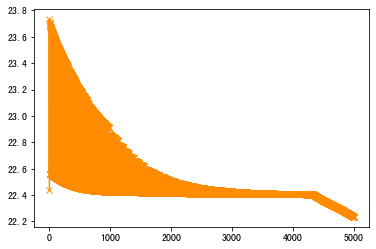

In [15]:
#hubei

i=0
data=read_data(paths[i])
city_name=citys[i]
param_path=param_paths_yes[i]
param_path=''


N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=5000,is_train=True,load_param_save=True,lr_init=0.00001,param_path=param_path)

#34695
#GT:31728
# 32633

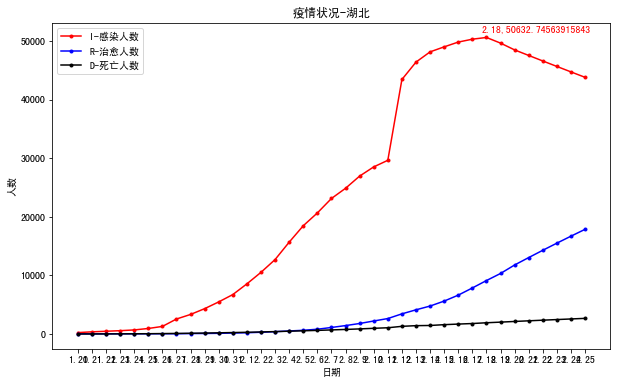

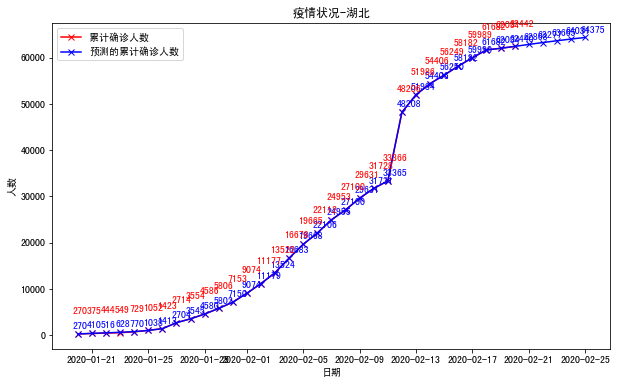

!!!!!!!!!!!!!!max_confirm_pred: 64375


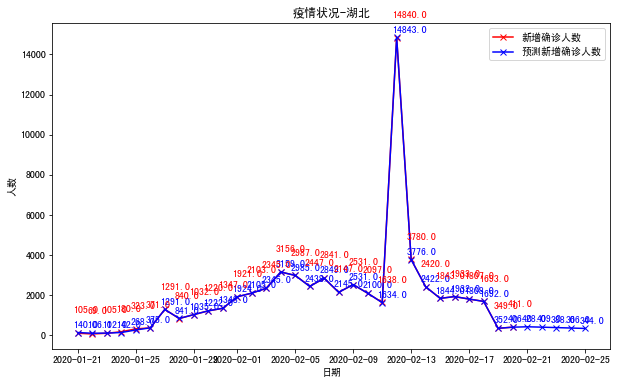

In [18]:
model = load_model_predict(model_city_date_path, data, param_pred=True,exp_decay=True, city_name=city_name, pred_date_len=5)

In [19]:
# model = load_model_predict(model_city_date_path, data, param_pred=True,exp_decay=True, city_name=city_name, pred_date_len=150)

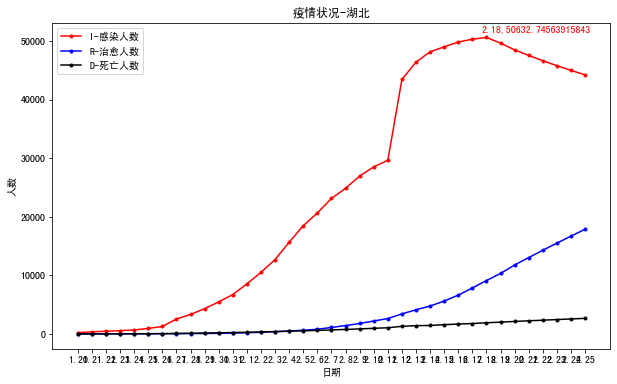

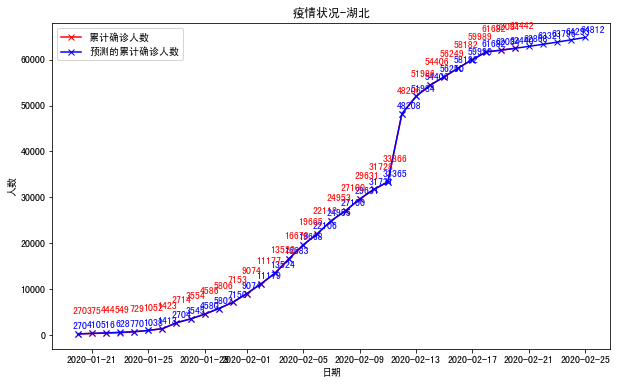

!!!!!!!!!!!!!!max_confirm_pred: 64812


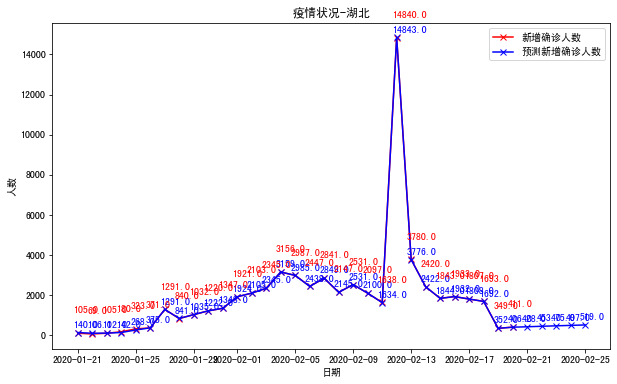

In [20]:
model = load_model_predict(model_city_date_path, data, param_pred=True,exp_decay=False, city_name=city_name, pred_date_len=5)

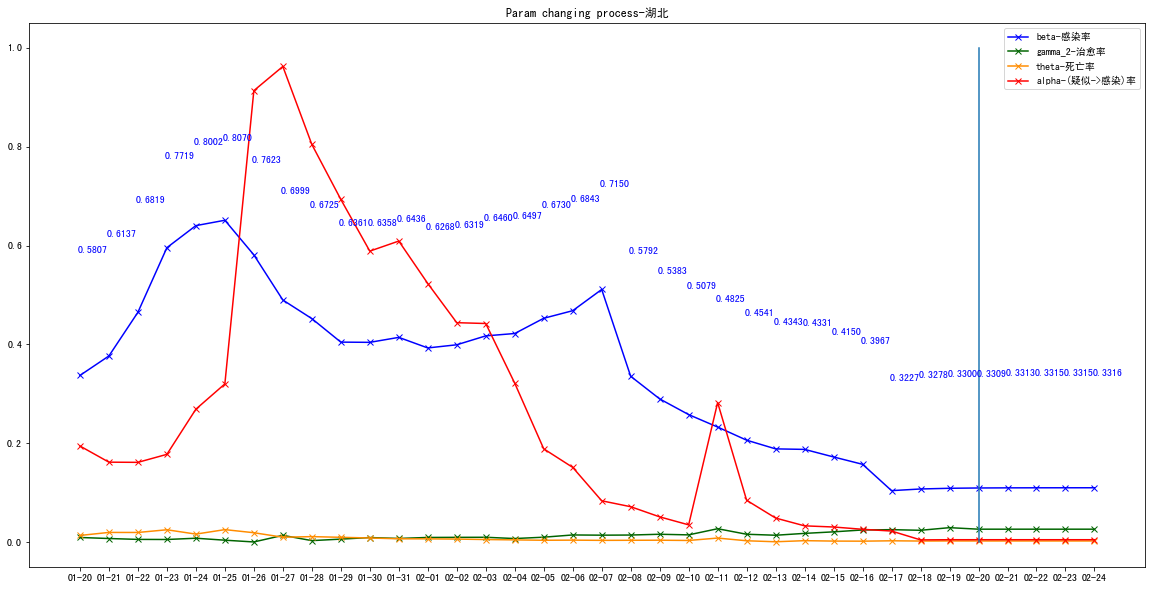

In [21]:
plot_param(model,'湖北',data=data,pred_date_len=5,xlen=20)

In [22]:
# param = load_param(model_city_date_path)
# param
# # model = load_model_predict(model_city_date_path, data, param_pred=False, city_name=city_name,pred_date_len=5)
# plot_param(model,city_name,data,xlen=15)

406064446
Training step:  1557
Loss: 5.70675578152313
Training step:  1558
Loss: 5.706262240075599
Training step:  1559
Loss: 5.705941753273039
Training step:  1560
Loss: 5.705444186899657
Training step:  1561
Loss: 5.705072749720088
Training step:  1562
Loss: 5.704567891021714
Training step:  1563
Loss: 5.7041420051157905
Training step:  1564
Loss: 5.703668200203174
Training step:  1565
Loss: 5.70333410035143
Training step:  1566
Loss: 5.702850659998332
Training step:  1567
Loss: 5.702501720477544
Training step:  1568
Loss: 5.701998979675189
Training step:  1569
Loss: 5.701566458318327
Training step:  1570
Loss: 5.7010981345721445
Training step:  1571
Loss: 5.700764339309842
Training step:  1572
Loss: 5.700287200619204
Training step:  1573
Loss: 5.699914557579453
Training step:  1574
Loss: 5.699433822015112
Training step:  1575
Loss: 5.699045826377773
Training step:  1576
Loss: 5.698573426363276
Training step:  1577
Loss: 5.698200886944177
Training step:  1578
Loss: 5.697699119377528


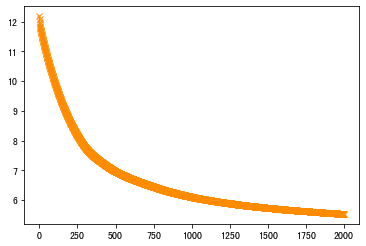

In [20]:
#wuhan

i=1
data=read_data(paths[i])
param_path=param_paths_yes[i]
city_name=citys[i]
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.000001,param_path=param_path)

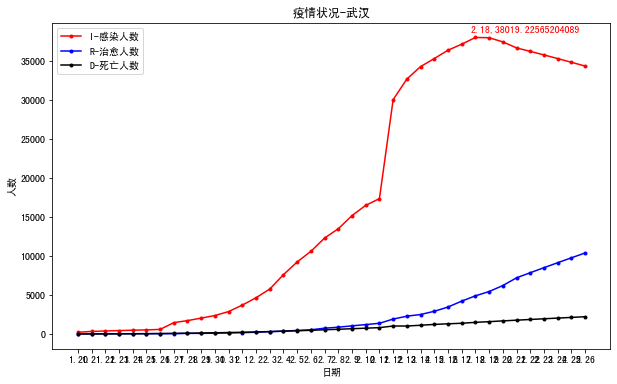

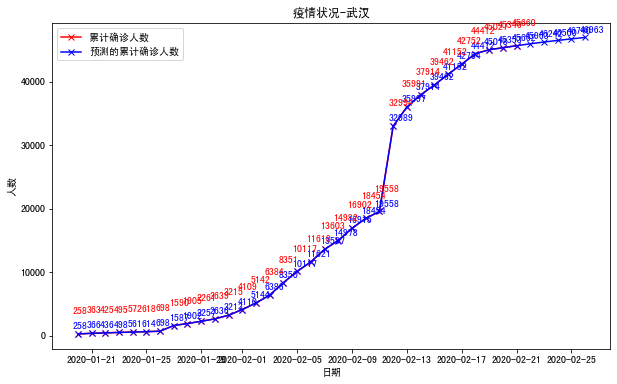

!!!!!!!!!!!!!!max_confirm_pred: 46963


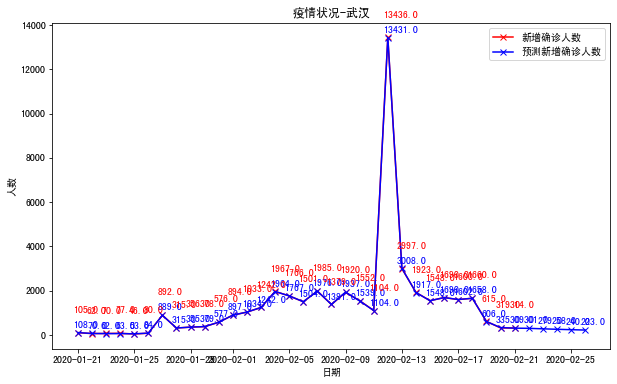

In [21]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name=city_name,pred_date_len=5)
# plot_param(model,city_name,data,xlen=15)

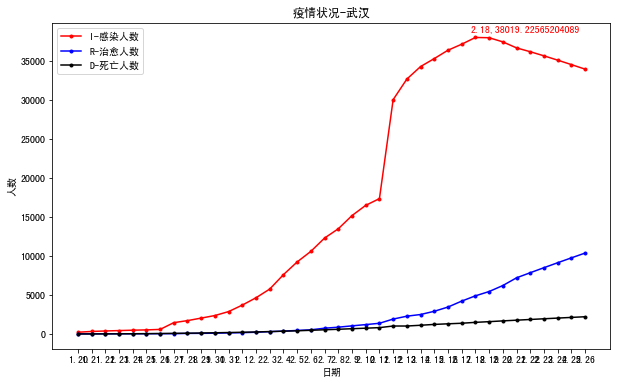

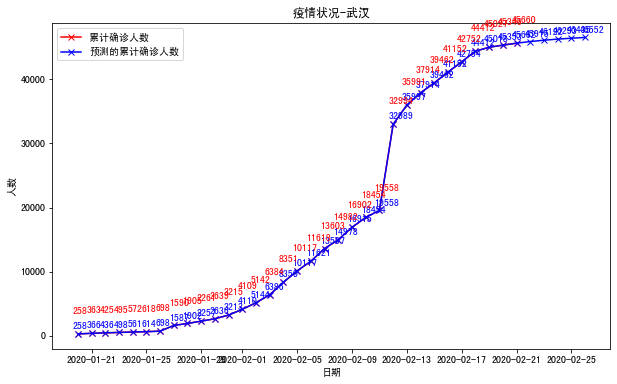

!!!!!!!!!!!!!!max_confirm_pred: 46552


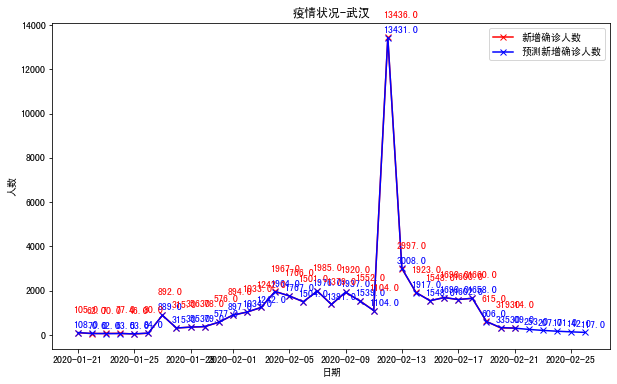

In [22]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=False, city_name=city_name,pred_date_len=5)

In [23]:
#shenzhen
param_path=''
i=2
data=read_data(paths[i])
city_name=citys[i]
param_path=param_paths_yes[i]
print(param_path)
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]

model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=3000,is_train=True,load_param_save=True,lr_init=0.0001,param_path=param_path)

g step:  364
Loss: 0.0017830600594730115
Training step:  365
Loss: 0.0016828811677816785
Training step:  366
Loss: 0.0017621255611211042
Training step:  367
Loss: 0.0016613525929253718
Training step:  368
Loss: 0.0017412648080955332
Training step:  369
Loss: 0.0016408242811703638
Training step:  370
Loss: 0.0017206404202154497
Training step:  371
Loss: 0.0016196256188688767
Training step:  372
Loss: 0.0017001039954895594
Training step:  373
Loss: 0.0015994001876556776
Training step:  374
Loss: 0.0016797848749355402
Training step:  375
Loss: 0.0015785258960629123
Training step:  376
Loss: 0.001659569393365418
Training step:  377
Loss: 0.001558602379970229
Training step:  378
Loss: 0.00163955442540621
Training step:  379
Loss: 0.0015380507683561606
Training step:  380
Loss: 0.0016196587700759084
Training step:  381
Loss: 0.0015184282120844189
Training step:  382
Loss: 0.001599946955903756
Training step:  383
Loss: 0.001498197602655972
Training step:  384
Loss: 0.0015803694357905285
Train

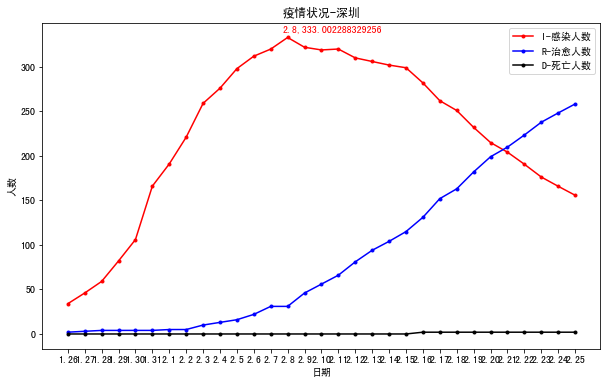

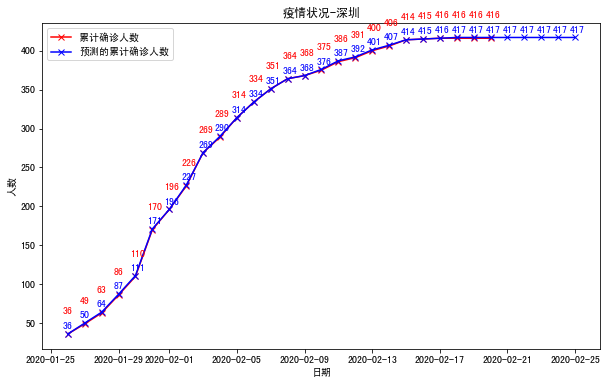

!!!!!!!!!!!!!!max_confirm_pred: 417


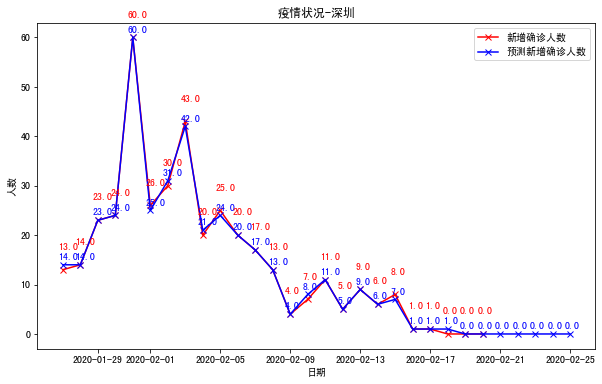

In [28]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name=city_name,pred_date_len=5)

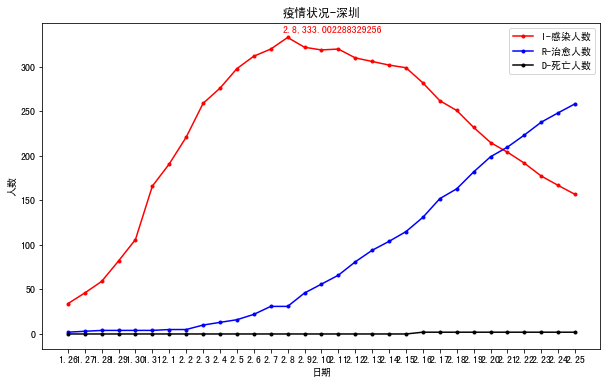

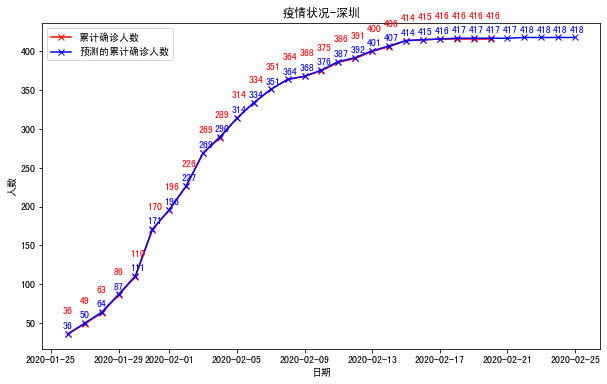

!!!!!!!!!!!!!!max_confirm_pred: 418


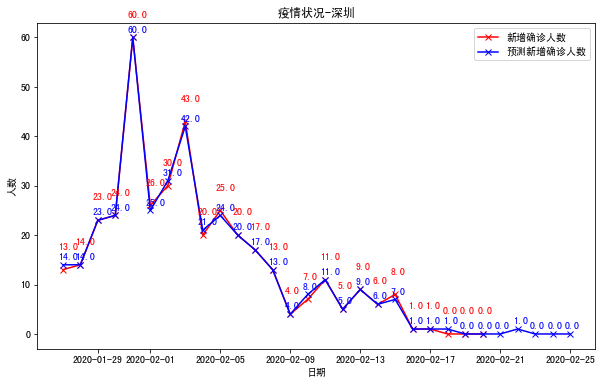

In [29]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=False, city_name=city_name,pred_date_len=5)

5262258785
Training step:  4559
Loss: 45.47107557656332
Training step:  4560
Loss: 45.47098258843451
Training step:  4561
Loss: 45.4701429264246
Training step:  4562
Loss: 45.469861967388056
Training step:  4563
Loss: 45.4691129168927
Training step:  4564
Loss: 45.46898942206748
Training step:  4565
Loss: 45.46826127121466
Training step:  4566
Loss: 45.46813450058595
Training step:  4567
Loss: 45.46741070110113
Training step:  4568
Loss: 45.467280874662876
Training step:  4569
Loss: 45.46648188611307
Training step:  4570
Loss: 45.46609668415397
Training step:  4571
Loss: 45.4652878701912
Training step:  4572
Loss: 45.46488431248657
Training step:  4573
Loss: 45.464119662969416
Training step:  4574
Loss: 45.46370945686292
Training step:  4575
Loss: 45.462987709692534
Training step:  4576
Loss: 45.46281625389337
Training step:  4577
Loss: 45.46214385978997
Training step:  4578
Loss: 45.46204249510146
Training step:  4579
Loss: 45.46128433223315
Training step:  4580
Loss: 45.4609566856886

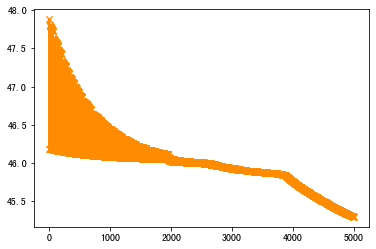

In [33]:
#china

i=3
data=read_data(paths[i])
city_name=citys[i]
param_path=param_paths_yes[i]
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]
# for i in range(5):
model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=2000,is_train=True,load_param_save=True,lr_init=0.00001,param_path=param_path)
# model_city_date_path = train_with_city_data(data,N,datetime,city_name)
# load_model_predict(model_city_date_path, data, param_pred=True, city_name=city_name)

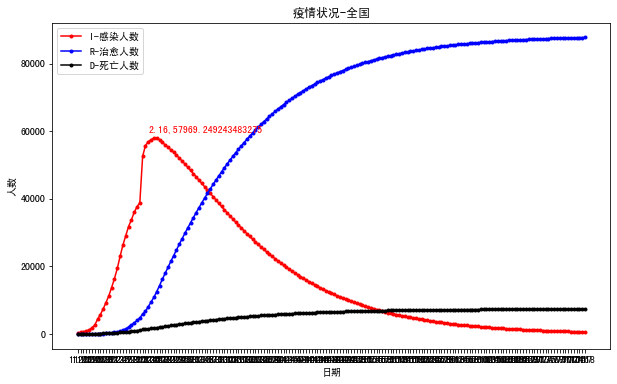

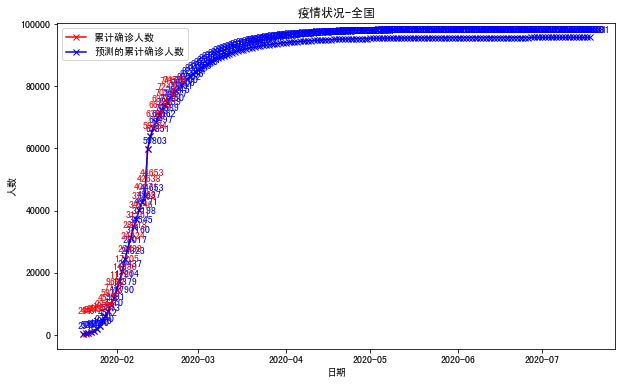

!!!!!!!!!!!!!!max_confirm_pred: 95681


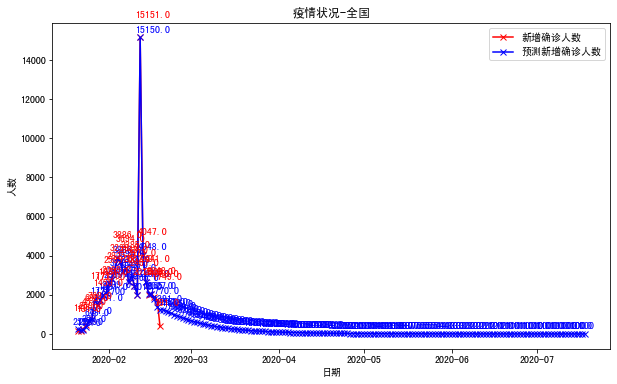

In [21]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name=city_name,pred_date_len=150)

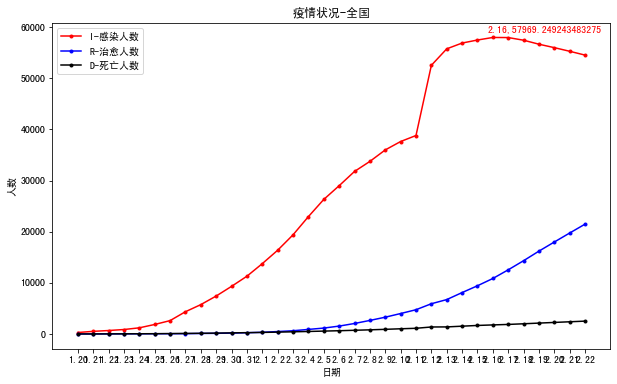

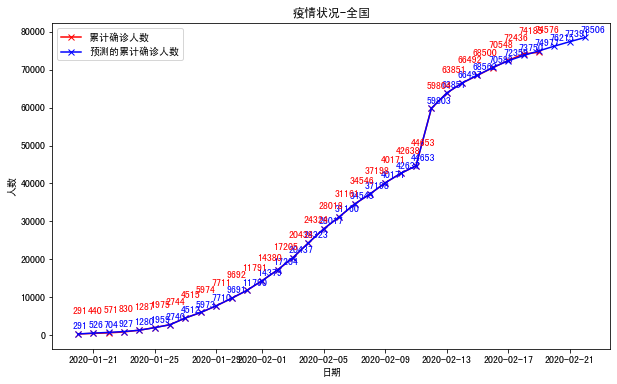

!!!!!!!!!!!!!!max_confirm_pred: 78506


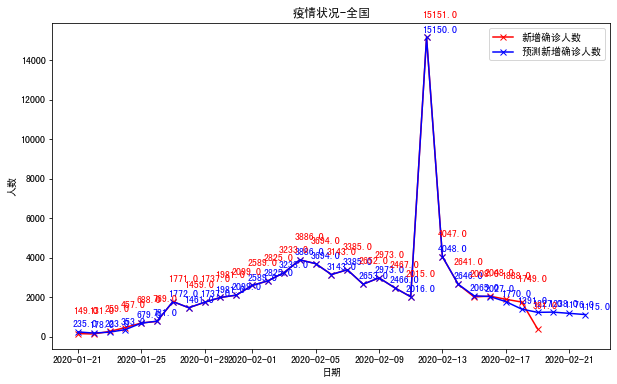

In [22]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name=city_name,pred_date_len=3)

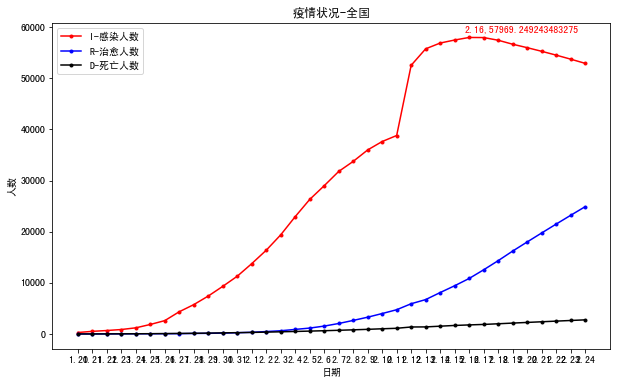

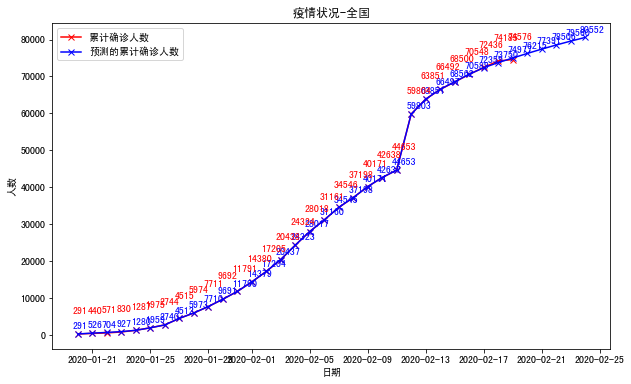

!!!!!!!!!!!!!!max_confirm_pred: 80552


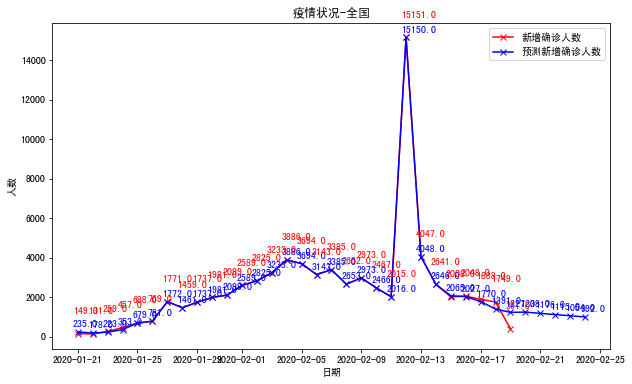

In [23]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name=city_name,pred_date_len=5)

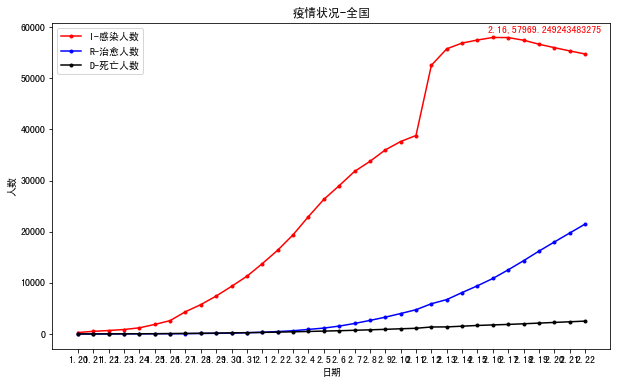

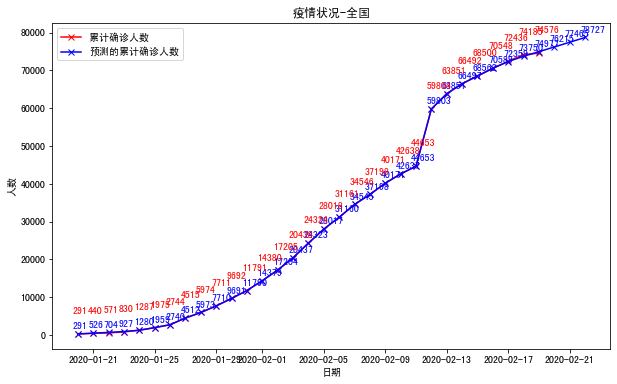

!!!!!!!!!!!!!!max_confirm_pred: 78727


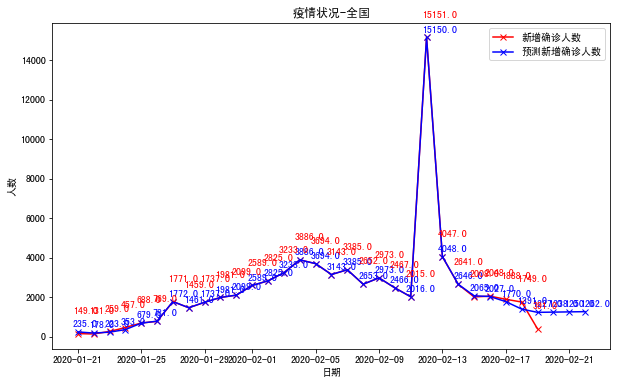

In [24]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=False, city_name=city_name,pred_date_len=3)

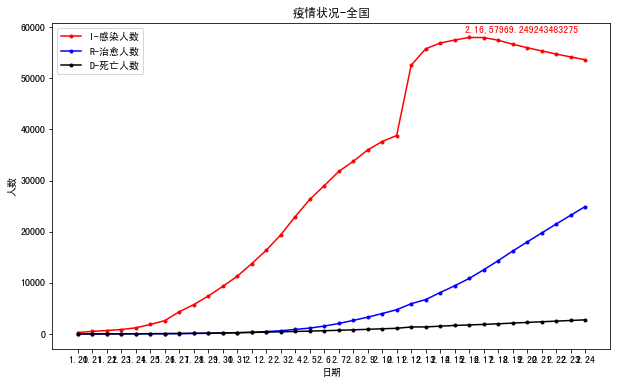

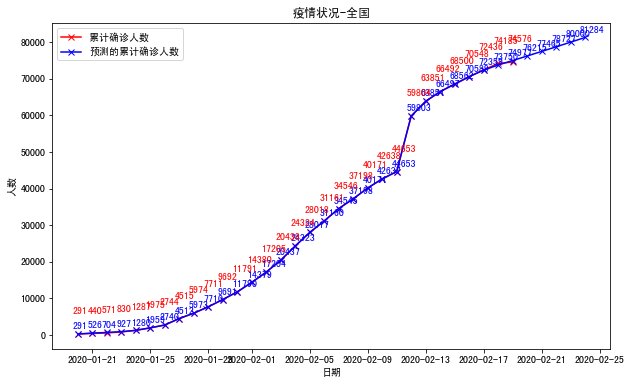

!!!!!!!!!!!!!!max_confirm_pred: 81284


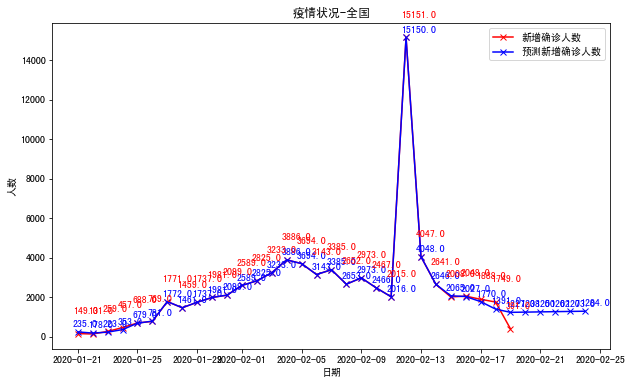

In [25]:
model = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=False, city_name=city_name,pred_date_len=5)

In [34]:
features=['time','I','confirmed','dead','cured','close_contact','suspected','under_medical_observation','quit_medical_observation']
i=4
data_hubei=read_data(paths[0])
data_china=read_data(paths[3])
data_nohubei = data_china-data_hubei
data_nohubei['time'] = data_china['time']
data_nohubei=data_nohubei[features]
for col in features:
    if col!='time':
        data_nohubei[col]=data_nohubei[col].apply(lambda x:0 if x<0 else x)
data_nohubei

time     I  confirmed  dead  cured  close_contact  suspected  \
0  2020-01-20    46         21     0      0            669         54   
1  2020-01-21    93         65     0      0           1016        136   
2  2020-01-22   155        127     0      0           3341        393   
3  2020-01-23   277        281     1      3           5854       1072   
4  2020-01-24   550        558     2      6           9515       1965   
5  2020-01-25   912        923     4      7          15442       2684   
6  2020-01-26  1310       1321     4      7          22405       5794   
7  2020-01-27  1782       1801     6     13          30929       6973   
8  2020-01-28  2390       2420     7     23          43442       9239   
9  2020-01-29  3083       3125     8     34          59913      12167   
10 2020-01-30  3822       3886     9     55          78435      15238   
11 2020-01-31  4551       4638    10     77          95912      17988   
12 2020-02-01  5183       5306    10    113         115273      19544   
13 2020-02-02  5837       6028    11    180         133495      21558   
14 2020-02-03  6669       6916    11    236         152027      23214   
15 2020-02-04  7263       7646    11    372         171115      23260   
16 2020-02-05  7819       8353    14    520         191816      24702   
17 2020-02-06  8308       9049    18    723         212429      26395   
18 2020-02-07  8635       9593    23    935         231454      27657   
19 2020-02-08  8857      10098    31   1210         248078       5304   
20 2020-02-09  9017      10540    37   1486         266932       5151   
21 2020-02-10  9094      10910    42   1774         284159       4988   
22 2020-02-11  9141      11287    45   2101         299211        553   
23 2020-02-12  9071      11598    57   2470         313154       4407   
24 2020-02-13  9319      11865     0   2592         326249       3940   
25 2020-02-14  8698      12086    66   3322         337035       3435   
26 2020-02-15  8386      12251    69   3796         346235       2985   
27 2020-02-16  8087      12366    74   4205         354582       2438   
28 2020-02-17  7678      12447    79   4690         361579       2048   
29 2020-02-18  7172      12503    83   5248         368331       1786   
30 2020-02-19  6638      12545    89   5818         375070       1466   
31 2020-02-20  6455      13023    92   6476         380341       1122   

    under_medical_observation  quit_medical_observation  
0                         591                        78  
1                         923                        93  
2                        3235                       106  
3                        5644                       210  
4                        9256                       259  
5                       14652                       790  
6                       21350                      1055  
7                       28573                      2356  
8                       39624                      3818  
9                       55315                      4598  
10                      70087                      8348  
11                      81640                     14272  
12                      94473                     20800  
13                     104529                     28966  
14                     112785                     39242  
15                     118791                     52324  
16                     122227                     69589  
17                     121988                     90441  
18                     121858                    109596  
19                     117745                    130333  
20                     114391                    152541  
21                     111521                    172638  
22                     107842                    191369  
23                     104078                    209076  
24                     100299                    225950  
25                      91716                    245319  
26                      84503    

82136674
Training step:  2559
Loss: 60.44255062385164
Training step:  2560
Loss: 60.43409420341684
Training step:  2561
Loss: 60.44252061181903
Training step:  2562
Loss: 60.43407678588691
Training step:  2563
Loss: 60.44231205352077
Training step:  2564
Loss: 60.43393846182795
Training step:  2565
Loss: 60.442101285123385
Training step:  2566
Loss: 60.43380392152938
Training step:  2567
Loss: 60.44207005608469
Training step:  2568
Loss: 60.43366602134665
Training step:  2569
Loss: 60.44186353995385
Training step:  2570
Loss: 60.433169978753085
Training step:  2571
Loss: 60.441639969897906
Training step:  2572
Loss: 60.43315812922166
Training step:  2573
Loss: 60.44161035961225
Training step:  2574
Loss: 60.433141150058795
Training step:  2575
Loss: 60.44158082794243
Training step:  2576
Loss: 60.43312423063362
Training step:  2577
Loss: 60.441551374667384
Training step:  2578
Loss: 60.43310737062133
Training step:  2579
Loss: 60.44152199956652
Training step:  2580
Loss: 60.43297264937

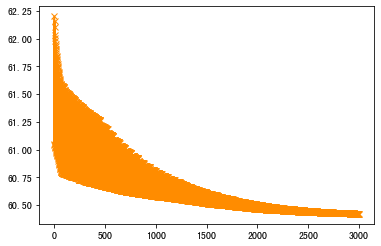

In [39]:
city_name = '非湖北'
param_path = 'models/'+'nohubei/'+yesterday
param_path=''
N = (max(data_china['E']) + max(data_china['I']) + max(data_china['cured']) + max(data_china['dead'])) * 100. - N_inits[0]
model_city_date_path = train_with_city_data(data_nohubei,N,datetime,city_name,max_epoches=3000,is_train=True,load_param_save=True,lr_init=0.0001,param_path=param_path)

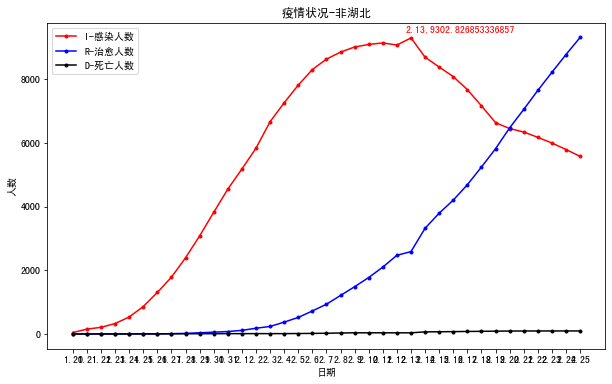

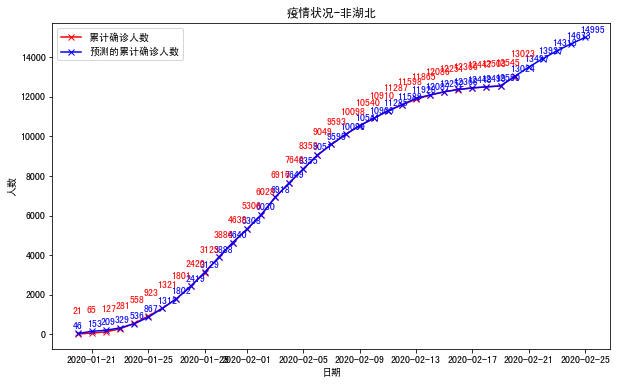

!!!!!!!!!!!!!!max_confirm_pred: 14995


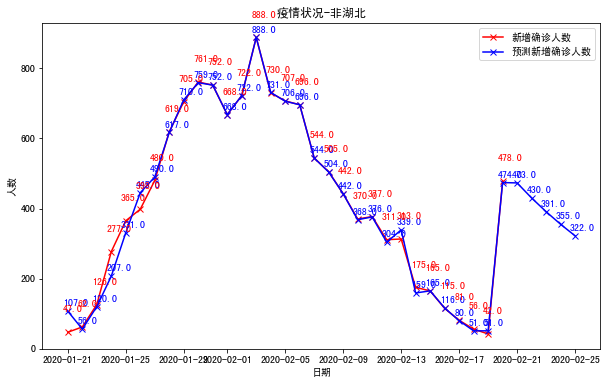

In [40]:
model = load_model_predict(model_city_date_path, data_nohubei, param_pred=True, exp_decay=True, city_name=city_name,pred_date_len=5)

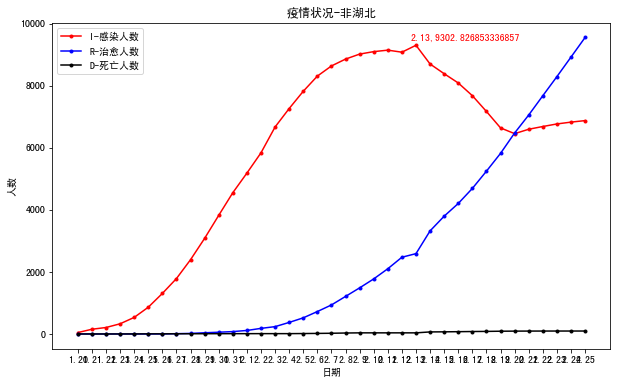

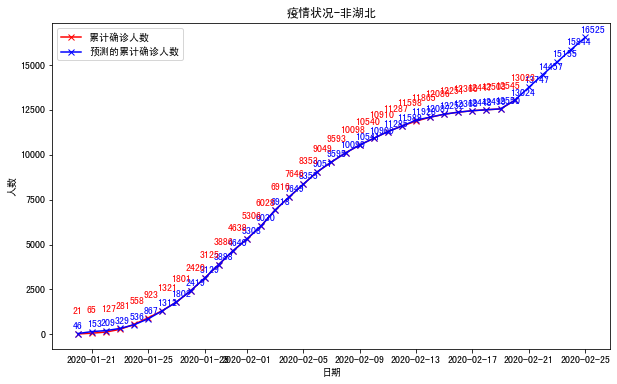

!!!!!!!!!!!!!!max_confirm_pred: 16525


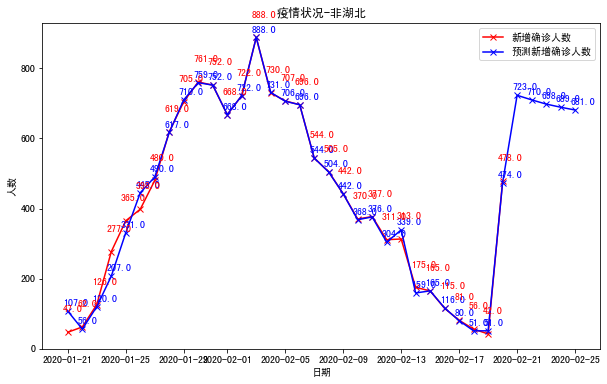

In [41]:
model = load_model_predict(model_city_date_path, data_nohubei, param_pred=True, exp_decay=False, city_name=city_name,pred_date_len=5)

In [47]:
def format_output(model_city_date_path, data, param_pred=False, city_name='深圳',c='confirmed', exp_decay=True, features=['I','cured','dead'], pred_date_len=5, data_dict={'累计':{},'新增':{}},data_dict_report={'累计':{},'新增':{}}):
    I_name,recover_name,dead_name = features
    model_pt = os.path.join(model_city_date_path,'model.pt')
    model = torch.load(model_pt)
    S = model.S_tensor_cur
    E = model.E_tensor_cur
    I = model.I_tensor_cur
    R = model.R_tensor_cur
    D = model.D_tensor_cur
    I_pred_old_float = (I.detach().numpy())
    R_pred_old_float = (R.detach().numpy())
    D_pred_old_float = (D.detach().numpy())
    S_pred_old_float = (S.detach().numpy())
    E_pred_old_float = (E.detach().numpy())

    I_pred_old = (I.detach().numpy()).astype(np.int)
    R_pred_old = (R.detach().numpy()).astype(np.int)
    D_pred_old = (D.detach().numpy()).astype(np.int)
    S_pred_old = (S.detach().numpy()).astype(np.int)
    E_pred_old = (E.detach().numpy()).astype(np.int)

    confirm_pred = cal_acc_confirm(I_pred_old_float,R_pred_old_float,D_pred_old_float)
    confirm_origin = get_data_acc_confirm(data,c=c)
    print(confirm_origin)
    new_confirm = cal_new_confirm(np.array(data[I_name]),np.array(data[recover_name]),np.array(data[dead_name]))
    new_confirm_pred = cal_new_confirm(I_pred_old_float,R_pred_old_float,D_pred_old_float)

    if param_pred:
        beta = []
        theta = []
        gamma_2 = []
        alpha = []
        for i in range(len(model.SEIR_cells)):
            beta.append(model.SEIR_cells[i].beta.detach().numpy()[0])
            gamma_2.append(model.SEIR_cells[i].gamma_2.detach().numpy()[0])
            theta.append(model.SEIR_cells[i].theta.detach().numpy()[0])
            alpha.append(model.SEIR_cells[i].alpha.detach().numpy()[0])
        # if city_name=='深圳':
        #     theta=get_recent_curve(theta)
        # print(len(theta))
        param = model.param_pred(beta,gamma_2,theta,alpha,exp_decay=exp_decay,pred_date_len=pred_date_len)

        print(param)
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(param=param, pred_date_len = pred_date_len)
    else:
        S_pred_tensor, I_pred_tensor, E_pred_tensor, R_pred_tensor, D_pred_tensor = model.pred(pred_date_len = pred_date_len)

    I_pred_new_float = (I_pred_tensor.detach().numpy())
    R_pred_new_float = (R_pred_tensor.detach().numpy())
    D_pred_new_float = (D_pred_tensor.detach().numpy())
    S_pred_new_float = (S_pred_tensor.detach().numpy())
    E_pred_new_float = (E_pred_tensor.detach().numpy())

    I_pred_new = (I_pred_tensor.detach().numpy()).astype(np.int)
    R_pred_new = (R_pred_tensor.detach().numpy()).astype(np.int)
    D_pred_new = (D_pred_tensor.detach().numpy()).astype(np.int)
    S_pred_new = (S_pred_tensor.detach().numpy()).astype(np.int)
    E_pred_new = (E_pred_tensor.detach().numpy()).astype(np.int)

    I_pred_total = np.concatenate((I_pred_old_float,I_pred_new_float),axis=0)
    R_pred_total = np.concatenate((R_pred_old_float,R_pred_new_float),axis=0)
    D_pred_total = np.concatenate((D_pred_old_float,D_pred_new_float),axis=0)
    S_pred_total = np.concatenate((S_pred_old_float,S_pred_new_float),axis=0)
    E_pred_total = np.concatenate((E_pred_old_float,E_pred_new_float),axis=0)

    # plot_SEIRD(data, I=I_pred_total, R=R_pred_total, D=D_pred_total, city=city_name, pred_date_len=pred_date_len)

    confirm_pred = cal_acc_confirm(I_pred_total,R_pred_total,D_pred_total)
    confirm_origin = get_data_acc_confirm(data,c=c)
    # plot_daily_acc(data, confirm_origin, confirm_pred, city=city_name, pred_date_len=pred_date_len)

    new_confirm_pred_total = cal_new_confirm(I_pred_total,R_pred_total,D_pred_total)
    new_confirm_pred_total
    # plot_daily_new(data, new_confirm, new_confirm_pred_total, city=city_name, pred_date_len=pred_date_len)
    new_R_pred_total = cal_new_R(R_pred_total)
    # print(new_R_pred_total)

    T_name = 'time'
    time_val = data[T_name].values

    max_time_val = data[T_name].values.max()
    pred_time = []
    for i in range(1, pred_date_len + 1):
        pred_time.append(max_time_val + np.timedelta64(i, 'D'))
    if pred_time == []:
        merge_time = time_val
    else:
        merge_time = np.concatenate((time_val, pred_time), axis=0)
    # pd.to_datetime()
    def format_datetime(x):
        xd = x.date()
        fxd = ''
        if xd.month<10 and xd.day<10:
            fxd = f'0{xd.month}-0{xd.day}'
        elif xd.month<10 and xd.day>=10: 
            fxd = f'0{xd.month}-{xd.day}'
        else:
            fxd = f'{xd.month}-{xd.day}'
        return fxd
    dates_list = [format_datetime(pd.to_datetime(d)) for d in merge_time]
    data_dict_report['累计'][city_name] = dict.fromkeys(dates_list)
    data_dict_report['新增'][city_name] = dict.fromkeys(dates_list[1:])
    temp=[]
    for i,p in enumerate(confirm_pred):
        data_dict['累计'][city_name].append([dates_list[i],p])
        data_dict_report['累计'][city_name][dates_list[i]]=p
    for i,p in enumerate(new_confirm_pred_total):
        data_dict['新增'][city_name].append([dates_list[i+1],p])
        data_dict_report['新增'][city_name][dates_list[i+1]]=p
    return data_dict,data_dict_report

date_time='02-21'
time='0220'
citys=['湖北','武汉','全国','深圳']
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv']
modelpath=['./models/hubei/'+date_time,'./models/wuhan/'+date_time,'./models/china/'+date_time,'./models/shenzhen/'+date_time]
# starts_date=['2020-01-20','2020-01-20','2020-01-20','2020-01-26'] #深圳从2020-01-26开始
# end_date=get_today_date()
def init_data_dict(citys):
    data_dict = dict.fromkeys(['累计','新增'])
    for k in data_dict.keys():
        data_dict[k] = dict.fromkeys(citys)
        for dc in data_dict[k].keys():
            data_dict[k][dc]=[]
    return data_dict

data_dict = init_data_dict(citys)
data_dict_exp_decay = init_data_dict(citys)
data_dict_report = init_data_dict(citys)
data_dict_report_exp_decay = init_data_dict(citys)
for i in range(len(citys)):
    city_name=citys[i]
    print(city_name)
    data=read_data(paths[i])
    data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, exp_decay=False, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
    data_dict_exp_decay,data_dict_report_exp_decay = format_output(modelpath[i], data, param_pred=True, exp_decay=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict_exp_decay,data_dict_report=data_dict_report_exp_decay)
print(data_dict)
# print(data_dict_report)

湖北
[  270   375   444   549   729  1052  1423  2714  3554  4586  5806  7153
  9074 11177 13522 16678 19665 22112 24953 27100 29631 31728 33366 48206
 51986 54406 56249 58182 59989 61682 62031 62442]
{'beta': [0.3309112899762162, 0.33129900645255744, 0.3314633966211802, 0.3315331308447569, 0.33156271808328996], 'gamma_2': [0.1616176951985109, 0.1616176951985109, 0.1616176951985109, 0.1616176951985109, 0.1616176951985109], 'theta': [0.04740505415444108, 0.047680841839199066, 0.047576789048594574, 0.04761614508295673, 0.04760127332946887], 'alpha': [0.06928171911944744, 0.06928171911944744, 0.06928171911944744, 0.06928171911944744, 0.06928171911944744]}
[  270   375   444   549   729  1052  1423  2714  3554  4586  5806  7153
  9074 11177 13522 16678 19665 22112 24953 27100 29631 31728 33366 48206
 51986 54406 56249 58182 59989 61682 62031 62442]
{'beta': [0.3214800190096225, 0.31525462765331685, 0.30914978966035417, 0.3031631705408073, 0.29729248101164424], 'alpha': [0.06928171911944744, 

In [48]:
print(data_dict_report)
print(data_dict_report_exp_decay)

{'累计': {'湖北': {'01-20': 270, '01-21': 410, '01-22': 516, '01-23': 628, '01-24': 770, '01-25': 1038, '01-26': 1413, '01-27': 2704, '01-28': 3545, '01-29': 4580, '01-30': 5802, '01-31': 7150, '02-01': 9074, '02-02': 11179, '02-03': 13524, '02-04': 16683, '02-05': 19668, '02-06': 22106, '02-07': 24955, '02-08': 27100, '02-09': 29631, '02-10': 31731, '02-11': 33365, '02-12': 48208, '02-13': 51984, '02-14': 54406, '02-15': 56250, '02-16': 58182, '02-17': 59990, '02-18': 61682, '02-19': 62034, '02-20': 62440, '02-21': 62868, '02-22': 63321, '02-23': 63796, '02-24': 64293, '02-25': 64812}, '武汉': {'01-20': 258, '01-21': 365, '01-22': 435, '01-23': 498, '01-24': 560, '01-25': 613, '01-26': 696, '01-27': 1583, '01-28': 1897, '01-29': 2250, '01-30': 2628, '01-31': 3202, '02-01': 4097, '02-02': 5130, '02-03': 6368, '02-04': 8328, '02-05': 10090, '02-06': 11596, '02-07': 13570, '02-08': 14959, '02-09': 16922, '02-10': 18454, '02-11': 19586, '02-12': 33005, '02-13': 36011, '02-14': 37921, '02-15': 3

In [49]:
print(data_dict_exp_decay)

{'累计': {'湖北': [['01-20', 270], ['01-21', 410], ['01-22', 516], ['01-23', 628], ['01-24', 770], ['01-25', 1038], ['01-26', 1413], ['01-27', 2704], ['01-28', 3545], ['01-29', 4580], ['01-30', 5802], ['01-31', 7150], ['02-01', 9074], ['02-02', 11179], ['02-03', 13524], ['02-04', 16683], ['02-05', 19668], ['02-06', 22106], ['02-07', 24955], ['02-08', 27100], ['02-09', 29631], ['02-10', 31731], ['02-11', 33365], ['02-12', 48208], ['02-13', 51984], ['02-14', 54406], ['02-15', 56250], ['02-16', 58182], ['02-17', 59990], ['02-18', 61682], ['02-19', 62034], ['02-20', 62440], ['02-21', 62868], ['02-22', 63277], ['02-23', 63665], ['02-24', 64031], ['02-25', 64375]], '武汉': [['01-20', 258], ['01-21', 365], ['01-22', 435], ['01-23', 498], ['01-24', 560], ['01-25', 613], ['01-26', 696], ['01-27', 1583], ['01-28', 1897], ['01-29', 2250], ['01-30', 2628], ['01-31', 3202], ['02-01', 4097], ['02-02', 5130], ['02-03', 6368], ['02-04', 8328], ['02-05', 10090], ['02-06', 11596], ['02-07', 13570], ['02-08', 

In [65]:
# data_dict = init_data_dict(citys)
# data_dict_report = init_data_dict(citys)
# for i in range(len(citys)):
#     city_name=citys[i]
#     data=read_data(paths[i])
#     data_dict,data_dict_report = format_output(modelpath[i], data, param_pred=True, city_name=city_name,features=['I','cured','dead'], pred_date_len=5, data_dict=data_dict,data_dict_report=data_dict_report)
print('SEIRD-ARIMA:')
for i in range(len(citys)):
    city_name=citys[i]
    s = '{}:{}'.format(city_name,data_dict_report['累计'][city_name]['02-21'])
    print(s)
print('SEIRD-exp-decay')
for i in range(len(citys)):
    city_name=citys[i]
    s = '{}:{}'.format(city_name,data_dict_report_exp_decay['累计'][city_name]['02-21'])
    print(s)


SEIRD-ARIMA:
湖北:62868
武汉:45656
深圳:417
全国:76354
SEIRD-exp-decay
湖北:62868
武汉:45712
深圳:417
全国:76354


## Make competiton prediction:  

In [84]:
citys=['湖北','武汉','深圳','全国']
N_inits=[59170000.,2870000.,13026600.]
datetime='02-21'
time='0220'
yesterday='02-20'
paths=['./ncov/data/hubei_截至'+time+'_24时.csv','./ncov/data/wuhan_截至'+time+'_24时.csv','./ncov/data/shenzhen_截至'+time+'_24时.csv','./ncov/data/nation_截至'+time+'_24时.csv']
param_paths_yes=['models/'+'hubei/'+yesterday,'models/'+'wuhan/'+yesterday,'models/'+'shenzhen/'+yesterday,'models/'+'china/'+yesterday]
i=3
data=read_data(paths[i])
city_name=citys[i]
# param_path=param_paths_yes[i]
param_path=''
N=0
if i == 3:
    N = (max(data['E']) + max(data['I']) + max(data['cured']) + max(data['dead'])) * 100.
else :
    N = N_inits[i]
model_city_date_path = train_with_city_data(data,N,datetime,city_name,max_epoches=3000,is_train=False,load_param_save=True,lr_init=0.0000001,param_path=param_path)

cured_ratio: 6.875341139184787
dead_ratio: 35.216323686152336
{'beta': [0.6847469733572167, 0.7318258313394179, 0.7693923739986678, 0.8308128845638851, 0.8399624227525926, 0.8583590705871635, 0.7953118447021272, 0.7198789399596038, 0.5966624987025778, 0.5761425628350839, 0.5687667926222975, 0.5533966614043178, 0.5402280274739145, 0.5369006489802031, 0.5338715106767126, 0.5306542898753305, 0.5243297712432733, 0.5218340714887655, 0.5191947032149911, 0.49568738696478754, 0.35254654226424037, 0.4121956191611149, 0.236283173950849, 0.20173095653787393, 0.17895655535765984, 0.18051024260767964, 0.16919374226668124, 0.1518711636734774, 0.087616554875252, 0.1257489965721504, 0.12574875384512268], 'theta': [0.11032940224312388, -0.12861699322752193, -0.12102032630762863, -0.12097693962877269, -0.10975914316126659, -0.116101921936745, -0.09996600464744056, 0.0772722899164217, -0.08129451334159243, -0.07611829531596173, -0.07030272901795714, 0.06313486879628259, 0.06440322550276578, -0.0625075321

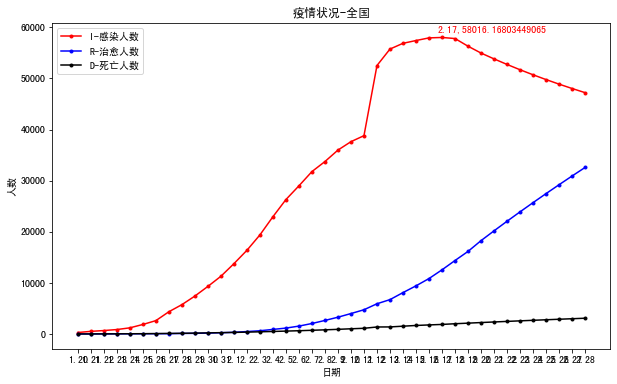

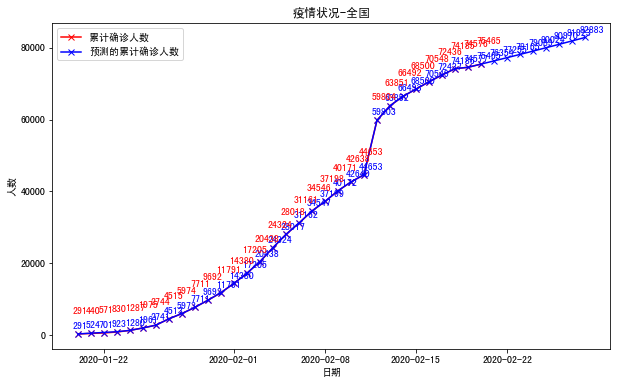

!!!!!!!!!!!!!!max_confirm_pred: 82883


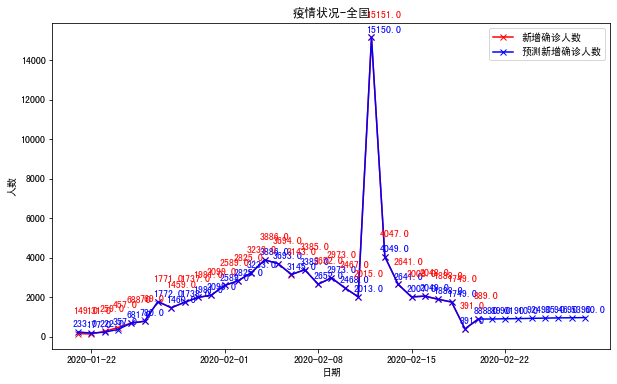

[  233.   177.   222.   357.   681.   780.  1772.  1460.  1738.  1981.
  2099.  2589.  2825.  3233.  3886.  3693.  3145.  3385.  2652.  2973.
  2468.  2013. 15150.  4049.  2641.  2007.  2049.  1888.  1749.   391.
   888.   889.   901.   910.   924.   935.   946.   953.   960.]
[   4.    9.   17.   11.    8.    5.    9.   44.   22.   48.   72.   86.
  147.  157.  261.  262.  388.  510.  600.  632.  716.  744. 1171.  813.
 1374. 1323. 1426. 1708. 1824. 1780. 2109. 1917. 1878. 1840. 1803. 1769.
 1736. 1705. 1675.]


In [85]:
model,new_C,new_R = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=False, city_name=city_name,return_new_C_R=True, pred_date_len=8)
print(new_C)
print(new_R)

In [86]:
new_R_pred = new_R[-7:]
new_R_pred

array([1878., 1840., 1803., 1769., 1736., 1705., 1675.])

In [87]:
# new_R_pred = new_R_pred
# new_R_pred

In [88]:
new_C_pred = new_C[-7:]
new_C_pred

array([901., 910., 924., 935., 946., 953., 960.])

In [89]:
new_C_pred = new_C_pred+505
new_C_pred

array([1406., 1415., 1429., 1440., 1451., 1458., 1465.])

In [90]:
sample = pd.read_csv('./ncov/data/sample.csv')
sample

index  confirmed_day1  confirmed_day2  confirmed_day3  confirmed_day4  \
0  total               0               1               2               3   

   confirmed_day5  confirmed_day6  confirmed_day7  recovery_day1  \
0               4               5               6              0   

   recovery_day2  recovery_day3  recovery_day4  recovery_day5  recovery_day6  \
0              1              2              3              4              5   

   recovery_day7  
0              6

In [91]:
sample = pd.read_csv('./ncov/data/sample.csv')
for i in range(7): 
    C_name = 'confirmed_day'+str(i+1)
    R_name = 'recovery_day'+str(i+1)
    sample[C_name] = new_C_pred[i].astype(int)
    sample[R_name] = new_R_pred[i].astype(int)
sample

index  confirmed_day1  confirmed_day2  confirmed_day3  confirmed_day4  \
0  total            1406            1415            1429            1440   

   confirmed_day5  confirmed_day6  confirmed_day7  recovery_day1  \
0            1451            1458            1465           1878   

   recovery_day2  recovery_day3  recovery_day4  recovery_day5  recovery_day6  \
0           1840           1803           1769           1736           1705   

   recovery_day7  
0           1675

In [92]:
def make_pred_dir(date, city='china'):
    save_root_path = './ncov/com_pred/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path
pred_dir = make_pred_dir('02-21')
submission_path = os.path.join(pred_dir,'submission_arima_21.csv')
sample.to_csv(submission_path,index=False)

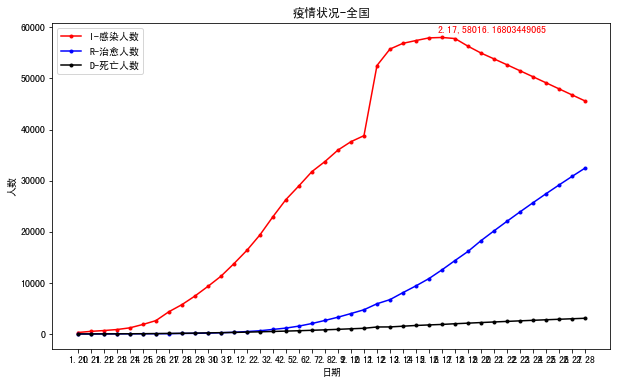

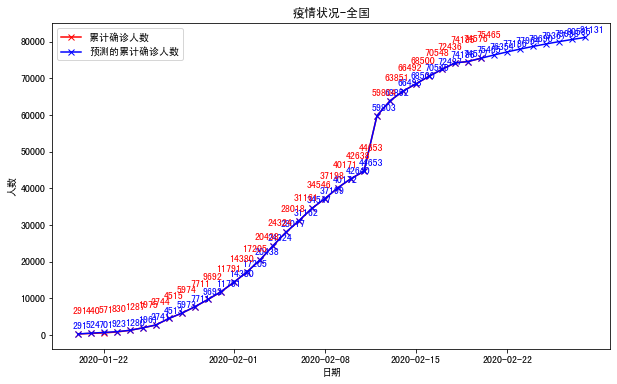

!!!!!!!!!!!!!!max_confirm_pred: 81131


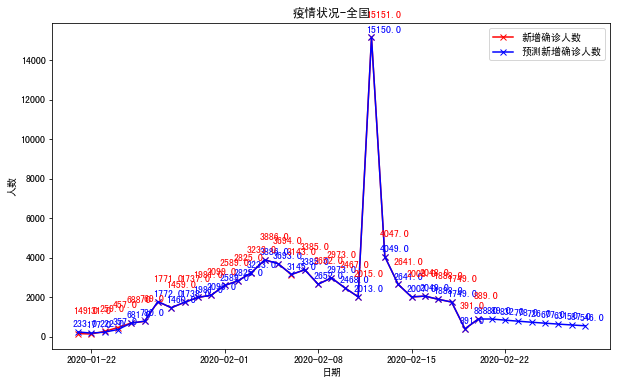

[  233.   177.   222.   357.   681.   780.  1772.  1460.  1738.  1981.
  2099.  2589.  2825.  3233.  3886.  3693.  3145.  3385.  2652.  2973.
  2468.  2013. 15150.  4049.  2641.  2007.  2049.  1888.  1749.   391.
   888.   889.   832.   778.   726.   677.   631.   587.   546.]
[   4.    9.   17.   11.    8.    5.    9.   44.   22.   48.   72.   86.
  147.  157.  261.  262.  388.  510.  600.  632.  716.  744. 1171.  813.
 1374. 1323. 1426. 1708. 1824. 1780. 2109. 1917. 1878. 1837. 1797. 1755.
 1714. 1673. 1632.]


In [93]:
model,new_C,new_R = load_model_predict(model_city_date_path, data, param_pred=True, exp_decay=True, city_name=city_name,return_new_C_R=True, pred_date_len=8)
print(new_C)
print(new_R)

In [94]:
new_R_pred = new_R[-7:]
new_R_pred

array([1878., 1837., 1797., 1755., 1714., 1673., 1632.])

In [95]:
# new_R_pred = 1.1*new_R_pred
# new_R_pred

In [96]:
new_C_pred = new_C[-7:]
new_C_pred

array([832., 778., 726., 677., 631., 587., 546.])

In [97]:
new_C_pred = new_C_pred+505
new_C_pred

array([1337., 1283., 1231., 1182., 1136., 1092., 1051.])

In [98]:
sample = pd.read_csv('./ncov/data/sample.csv')
for i in range(7): 
    C_name = 'confirmed_day'+str(i+1)
    R_name = 'recovery_day'+str(i+1)
    sample[C_name] = new_C_pred[i].astype(int)
    sample[R_name] = new_R_pred[i].astype(int)
sample

index  confirmed_day1  confirmed_day2  confirmed_day3  confirmed_day4  \
0  total            1337            1283            1231            1182   

   confirmed_day5  confirmed_day6  confirmed_day7  recovery_day1  \
0            1136            1092            1051           1878   

   recovery_day2  recovery_day3  recovery_day4  recovery_day5  recovery_day6  \
0           1837           1797           1755           1714           1673   

   recovery_day7  
0           1632

In [99]:
def make_pred_dir(date, city='china'):
    save_root_path = './ncov/com_pred/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path
pred_dir = make_pred_dir('02-21')
submission_path = os.path.join(pred_dir,'submission_exp_decay_21.csv')
sample.to_csv(submission_path,index=False)

In [74]:
mse = [1443.9790202157074,1450.4794024276493,1463.205886811903,1476.2904650362248,1487.9961131054317,1498.0034268753332,1505.0789427862692,1509.7082083455687,1513.9079579819024,1517.7066686248297,1521.3079751087605,1524.758903421485,1528.4836242637225,1533.0081514128385,1538.4684214974534,1544.709128692492,1551.7974282106265,1559.8326309984873,1568.7291515781694,1578.6138276746585]
sum(mse)

30316.06533506951

In [ ]:
beta = [0.6880590749912103, 0.731365569440861, 0.7590128493113747, 0.8217246603393512, 0.8378739784041495, 0.8571955594875855, 0.7946709817620398, 0.7194231108564486, 0.5963249287245864, 0.5759178643460326, 0.5685197288608052, 0.553251149632845, 0.5398918002025193, 0.5364501382302032, 0.5334100054974589, 0.5305545515884974, 0.5245520868460465, 0.5229766508829818, 0.5211485952288218, 0.5009293835715037, 0.36171498586850215, 0.4239539886873498, 0.25592465568103984, 0.22430381590020754, 0.20264972454863128, 0.20264972454863128]

alpha = [0.5491301886199877, 0.5114538653424401, 0.5204039194195985, 0.5761937884361077, 0.709459001482511, 0.7251218937152302, 0.9264891284208429, 0.8679889400937711, 0.7979923744444479, 0.8083599247060945, 0.7732990328948632, 0.7654048033299042, 0.7311276658940528, 0.7070996692708386, 0.6994839437150148, 0.6213255726954602, 0.5048923138443937, 0.4540340368001087, 0.35572797380647014, 0.332267660654391, 0.2758729819841826, 0.24114621233200462, 0.6201772712177571, 0.3887449510640146, 0.3226278984985009, 0.2833061947975532]

In [ ]:
beta_exp = beta[np.argmax(beta):]
beta_exp


In [ ]:
np.argmax(beta)

In [ ]:
class fc_module(torch.nn.Module):
    def __init__(self, w1, b1):
        super(fc_module, self).__init__()
        self.w1=w1
        self.b1=b1
    def forward(self, X):
        return self.w1*X+self.b1

class exp_model(torch.nn.Module):
    def __init__(self, date_len):
        super(exp_model, self).__init__()
        self.w1 = Parameter(torch.tensor([0.8],requires_grad=True))
        # self.w2 = Parameter(torch.tensor([1.],requires_grad=True))
        self.b1 = Parameter(torch.tensor([0.],requires_grad=True))
        # self.b2 = Parameter(torch.tensor([0.],requires_grad=True))
        self.date_len = date_len
        # self.fc_modules = torch.nn.ModuleList()
        # for i in range(self.date_len):
        #     self.fc_modules.append(fc_module(self.w1,self.b1))
        self.fc = fc_module(self.w1,self.b1)
    
    def forward(self, X):
        pred_tensor = torch.zeros((self.date_len,))
        # out = self.fc_modules[0](X)
        out = self.fc(X)
        pred_tensor[0] = out
        for i in range(1, self.date_len):
            # out = self.fc_modules[i](out)
            out = self.fc(out)
            pred_tensor[i]=out
        return pred_tensor

    def pred(self, X):
        return fc_module(self.w1,self.b1)(X)

In [ ]:
date_len = len(beta_exp)-1
beta_pred_model = exp_model(date_len)
input_tensor = torch.tensor([beta_exp[0]])
beta_pred = beta_pred_model(input_tensor)
beta_pred

In [ ]:
len(beta_pred)

In [ ]:
len(beta_exp[1:])

In [ ]:
date_len = len(beta_exp)-1
beta_pred_model = exp_model(date_len)
input_tensor = torch.tensor([beta_exp[0]])
beta_pred = beta_pred_model(input_tensor)
max_epoches = 300
lr = 0.01
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
loss_list=[]
optimizer = optim.Adam(beta_pred_model.parameters(), lr=lr, betas=(beta1, 0.999))
loss_min = 1e8
input_tensor = torch.tensor([beta_exp[0]])
gt_tensor = torch.tensor(beta_exp[1:])
loss_fn = torch.nn.MSELoss()
for epoch_step in range(max_epoches):
    beta_pred = beta_pred_model(input_tensor)
    loss = loss_fn(beta_pred[:-1], gt_tensor[:-1])+100*loss_fn(beta_pred[-1], gt_tensor[-1])
    print("Loss: {}".format(loss))
    learning_rate = lr_decay(epoch_step,lr,decay_steps=10)
    optimizer = optim.Adam(beta_pred_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



In [ ]:
beta_pred_model.w1

In [ ]:
beta_pred_model.b1

In [ ]:
beta_pred_model.pred(beta_exp[-1])

In [ ]:
beta_pred = beta_pred_model(input_tensor)
beta_pred_np = beta_pred.detach().numpy()
plt.figure(figsize=(6, 10))
plt.plot(beta_exp[1:], color='darkorange', label='beta gt', marker='x')
plt.plot(beta_pred_np,color='darkblue',label='beta pred',marker='x')
plt.legend()
plt.show()

In [ ]:
def make_pred_dir(date, city='china'):
    save_root_path = './ncov/com_pred/'
    model_city_path = os.path.join(save_root_path, city)

    model_city_date_path = os.path.join(model_city_path, date)

    if not os.path.exists(model_city_date_path):
        print(model_city_date_path)
        os.makedirs(model_city_date_path)
    return model_city_date_path
pred_dir = make_pred_dir('02-16')
submission_path = os.path.join(pred_dir,'submission_first.csv')
sample.to_csv(submission_path,index=False)

In [ ]:
# def beta_pred(self, beta_list):
#     check_positive = lambda x:0 if x <=0 else np.sqrt(x)
#     sqrt_datas=[beta_list]
#     datas = [list(np.square(d)) for d in sqrt_datas]
#     params=['beta']
#     param_dict={}
#     for i in range(len(params)):
#         param=params[i]
#         data=datas[i]
#         print("data:",data)
#         data_copy=pd.DataFrame(data,columns=[param])
#         dif_data=data_copy
#         dif_data_list=[data_copy.values]
#         dif=0
#         p_value = adfuller(data_copy[param])[1]
#         while p_value>0.05:
#             dif=dif+1
#             dif_data=dif_data.diff(1).dropna()
#             dif_data_list.append(dif_data.values)
#             p_value= adfuller(dif_data[param])[1]  
#         pmax = int(len(data)/10) 
#         qmax = int(len(data)/10)
#         if dif>1:
#             d=0
#             data=dif_data
#         else:
#             d=dif
#         bic_matrix = [] #bic矩阵
#         for p in range(pmax+1):
#             tmp = []
#             for q in range(qmax+1):
#                 try: #存在部分报错，所以用try来跳过报错。
#                     tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
#                 except:
#                     tmp.append(None)
#             bic_matrix.append(tmp)
#         bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
#         p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
        
#         model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
#         param_dict[param]=model.forecast(2)[0]
#         print(param_dict[param])
#         if dif>1:
#             dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
            for i in range(dif,0,-1):
                # dif_data_list[i-1]=np.append(dif_data_list[i-1],dif_data_list[i][-2:]+dif_data_list[i-1][-2:])
                dif_data_list[i-1]=np.append(dif_data_list[i-1],dif_data_list[i][-pred_date_len:]+dif_data_list[i-1][-pred_date_len:])
            param_dict[param]=dif_data_list[0][-pred_date_len:]
#     # update beta by arima
#     param_dict['beta'][0] = check_positive(param_dict['beta'][0])
#     # param_dict['beta'][1] = check_positive(param_dict['beta'][1])
#     self.SEIR_cells[-1].update_beta(param_dict['beta'][0])
    
#     return param_dict['beta'][1]

# def param_pred(self,beta_list,gamma_2_list,theta_list,alpha_list):
#     check_positive = lambda x:0 if x <=0 else np.sqrt(x)
#     sqrt_datas=[gamma_2_list,theta_list,alpha_list]
#     datas = [list(np.square(d)) for d in sqrt_datas]
#     params=['gamma_2','theta','alpha']
#     param_dict={}

#     param_dict['beta'] = self.beta_pred(beta_list[:-1])

#     for i in range(len(params)):
#         param=params[i]
#         data=datas[i]
#         data_copy=pd.DataFrame(data,columns=[param])
#         dif_data=data_copy
#         dif_data_list=[data_copy.values]
#         dif=0
#         p_value = adfuller(data_copy[param])[1]
#         while p_value>0.05:
#             dif=dif+1
#             dif_data=dif_data.diff(1).dropna()
#             print(dif_data)
#             dif_data_list.append(dif_data.values)
#             p_value= adfuller(dif_data[param])[1] 
#         pmax = int(len(data)/10) 
#         qmax = int(len(data)/10)
#         if dif>1:
#             d=0
#             data=dif_data
#         else:
#             d=dif
#         bic_matrix = [] #bic矩阵
#         for p in range(pmax+1):
#             tmp = []
#             for q in range(qmax+1):
#                 try: #存在部分报错，所以用try来跳过报错。
#                     tmp.append(smt.ARIMA(data, (p,d,q)).fit().bic)
#                 except:
#                     tmp.append(None)
#             bic_matrix.append(tmp)
#         bic_matrix = pd.DataFrame(bic_matrix) #从中可以找出最小值
#         p,q = bic_matrix.stack().astype('float64').idxmin() #先用stack展平，然后用idxmin找出最小值位置。
        
#         model = smt.ARIMA(data, (p,d,q)).fit() #建立ARIMA(0, 1, 1)模型
#         model.summary2() #给出一份模型报告
#         param_dict[param]=model.forecast(1)[0][0]
#         if dif>1:
#             dif_data_list[-1]=np.append(dif_data_list[-1],param_dict[param])
#             for i in range(1,dif+1,1):
#                 dif_data_list[-i-1]=np.append(dif_data_list[-i-1],dif_data_list[-i][-1]+ dif_data_list[-i-1][-1])
#             param_dict[param]=dif_data_list[0][-1]
#     for k,v in param_dict.items():
#         param_dict[k]=check_positive(v)
#     return param_dict